## Overview
* Country: United States, France, Germany, Japan, United Kingdom, Italy, Canada
* Time period: 1950-2018, 69 years
* Target variable: `ngdp_rpch` for annual data, `ngdp_r_sa_pcha` and `ngdp_r_sa_pchy` (respectively) for quarterly data
* Train-test split: 1950-2009 (train, ≤ x  years, depends on data availability), x - y (test, z years)   
  _Need further discussion. Here I divide the dataset by x/y just as the working paper did. Now for the ML model family we do not need to do such split._
  
* LSTM Model
* CNN Model

## Import packages

In [1]:
# Module 1: Importing the libraries

import tensorflow as tf
from tensorflow import keras
keras = tf.keras

# Print all outputs in a code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Importing the libraries
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline


# from tf.random import set_seed

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import ModelCheckpoint

# from keras.callbacks import ResetStatesCallback()

from keras.layers import Conv1D
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten,Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
from tensorflow import random
# from tensorflow.random import set_seed

In [4]:
# Set Seed

seed_global = 42

# Source: https://machinelearningmastery.com/reproducible-results-neural-networks-keras/

from numpy.random import seed
seed(seed_global)

#  Giving an eror 
# from tensorflow import set_random_seed
# set_random_seed(seed_global)

# Source: https://stackoverflow.com/questions/58638701/importerror-cannot-import-name-set-random-seed-from-tensorflow-c-users-po

tf.random.set_seed(seed_global)

# Copy paste this code snippet in every model code chunk 
seed(seed_global)
tf.random.set_seed(seed_global)

# --Ignore--
# tf.random.set_seed(seed)
# # This is giving me an error

# #  Global Seed
# # random.seed (2019) 

## Get data

In [5]:
%%bigquery gdp_quarterly_q

SELECT *
FROM `deep-nexus.temp_for_imf_data.WEO_G7_Quarterly`
ORDER BY time

In [6]:
gdp_quarterly_q.year = (gdp_quarterly_q.time+40)//4 + 1950
gdp_quarterly_q.quarter = (gdp_quarterly_q.time+40)%4 + 1
gdp_quarterly_q.time = gdp_quarterly_q.year.astype('str') + 'Q' + gdp_quarterly_q.quarter.astype('str')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [7]:
gdp_quarterly_q = pd.DataFrame(gdp_quarterly_q)
gdp_quarterly_q.head(5)

,country,ifscode,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
0,United States,111,1950Q1,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
1,United Kingdom,112,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,72.776393,NaN,72.776393,NaN,NaN,NaN,NaN
2,France,132,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,47.016824,NaN,47.016824,NaN,NaN,NaN,NaN
3,Germany,134,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Italy,136,1950Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Selecting a subset of countries
gdp_quarterly_q.country.unique()

selected_countries = list(gdp_quarterly_q.country.unique())[0:1]
print("\nSelected Countries: \n")
selected_countries

array(['United States', 'United Kingdom', 'France', 'Germany', 'Italy',
       'Canada', 'Japan'], dtype=object)


Selected Countries: 



['United States']

In [9]:
# dataset_2 = gdp_quarterly_q

# for i in selected_countries:
#    dataset_2[i] = gdp_quarterly_q[gdp_quarterly_q['country'] == i]

# https://stackoverflow.com/questions/51583888/concatenate-dataframe-name-with-variable-value-python

In [10]:
# # Random Forest Regressor

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# # random forest model creation

# # Set Seed
# seed(seed_global)
# tensorflow.random.set_seed(seed_global)


# rfr = RandomForestRegressor(n_estimators = 1000)

# rfr.fit(X_train, y_train)

# # predictions
# y_pred = rfr.predict(X_test)

# metrics_mse["random_forest"] =  mean_squared_error(y_test, y_pred)

# print("Random Forest Test MSE: ", mean_squared_error(y_test, y_pred))

In [11]:
# # Variable Importance

# # Top i factors by importance

# i = 20
# importances = rf_reg.feature_importances_
# indices = np.argsort(importances)[-(i-1):]
# features = X.columns

# plt.figure(figsize=(6,6))
# plt.title('Feature Importances - Random Forest Regressor')
# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), features[indices])
# plt.xlabel('Relative Importance')

In [12]:
# Filter data by country

dataset = gdp_quarterly_q[gdp_quarterly_q['country'].isin(selected_countries)]

dataset = pd.DataFrame(dataset)
# print ("#", "column name", "missing values")
# for i in range(len(dataset.columns)):
#     print(i, dataset.columns[i], " ", dataset.iloc[i].isnull().count())

dataset.head(5)

,country,ifscode,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
0,United States,111,1950Q1,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
7,United States,111,1950Q2,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
14,United States,111,1950Q3,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
21,United States,111,1950Q4,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,...,NaN,NaN,NaN,301.782705,NaN,301.782705,NaN,NaN,NaN,NaN
28,United States,111,1951Q1,NaN,NaN,NaN,0.062002,NaN,NaN,NaN,...,NaN,NaN,NaN,348.993057,NaN,348.993057,8.709073,11.508033,10.159067,12.875869


## Process data

In [13]:
dataset_input = dataset
dataset_input = dataset_input.drop(columns = ['country', 'ifscode', 'time', 'ngdp_r_sa_pcha', 'ngdp_r_sa_pchy', 'ngdp_dpchy'])
dataset_input.tail(5)

,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,247.273333,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,249.250333,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,250.578667,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,251.828667,2.010362,2.632912,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725
1925,18819.741667,11057.4,156.776667,0.162071,111.370,3.800000,2605.7,-0.011512,13066.3,0.357148,...,252.759000,1.485933,2.218463,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725


In [14]:
# Outcome vaiable (Column Name) = ngdp_r_sa_pcha

outcome_variable = "ngdp_r_sa_pcha"
predicted_variable = "1_step_ahead_" + outcome_variable

dataset_1 = dataset_input
dataset_1["time"] = dataset["time"]
# dataset_1[num_cols] = dataset[num_cols]
dataset_1[outcome_variable] = dataset[outcome_variable]

dataset_1[predicted_variable] = dataset_1[outcome_variable].shift(-1)

# # Source: https://stackoverflow.com/questions/20095673/shift-column-in-pandas-dataframe-up-by-one

dataset_1 = dataset_1[:-1] 

dataset_1.tail(5)

,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,time,ngdp_r_sa_pcha,1_step_ahead_ngdp_r_sa_pcha
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,2017Q3,3.202964,3.545494
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,2017Q4,3.545494,2.552107
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q1,2.552107,3.512025
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q2,3.512025,2.926498
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2018Q3,2.926498,1.089155


In [15]:
# Output Columns

# ngdp_r_sa_pcha: WEO: Gross domestic product, constant prices, seasonally adjusted, quarter-over-quarter percent change, annualized (Percent, Units).

dataset_Y = dataset_1[["time", predicted_variable]]
dataset_Y.tail(5)

,time,1_step_ahead_ngdp_r_sa_pcha
1890,2017Q3,3.545494
1897,2017Q4,2.552107
1904,2018Q1,3.512025
1911,2018Q2,2.926498
1918,2018Q3,1.089155


In [28]:
# Window size and crearting the lagged columns

#  Using a lag = 0 for identifying initial variable importance by fitting a randowm forest 
# window size 
lag = 10
dataset_input_l = dataset_1

# Drop the 1) preducted outcome variable and 2) time variable 

dataset_input_l = dataset_input_l.drop(columns = ["time", predicted_variable])

print("Before adding the lagged variables to the input dataset: ")
dataset_input_l.tail(5)

# Lagging each column in num_columns by the entire range of lag factors

for j in dataset_input_l.columns:
    for i in range(1, (lag + 1), 1):
        new_col = str(j)+"-"+str(i)
        dataset_input_l[str(new_col)] = dataset_input_l[str(j)].shift(i)
    
print("After adding the lagged variables to the input dataset: ")
dataset_input_l.tail(5)

Before adding the lagged variables to the input dataset: 


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,pcpi_sa_pcha,pcpi_sa_pchy,pppgdp,pppsh,pppwgt,tmgwgt,tmwgt,txgwgt,txwgt,ngdp_r_sa_pcha
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,2.153214,1.981427,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.202964
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,3.141889,2.109865,19519.40,15.284951,19519.40,2221.075,2739.425,1444.025,2220.625,3.545494
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,3.236639,2.222997,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.552107
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,2.148827,2.668825,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,3.512025
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,2.010362,2.632912,20580.25,15.195560,20580.25,2379.800,2932.075,1538.375,2356.725,2.926498


After adding the lagged variables to the input dataset: 


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
1890,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,12586.3,0.586595,...,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969,2.998835,3.177823
1897,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,12729.7,1.139334,...,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969,2.998835
1904,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,12782.9,0.417920,...,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969
1911,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,12909.2,0.988039,...,2.552107,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624
1918,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,13019.8,0.856753,...,3.512025,2.552107,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962


In [29]:
# Combining Input and Output Values

# X1 = dataset_input
# X = pd.concat([X1, X2, dataset_Y], axis=1)
X = pd.concat([dataset_Y, dataset_input_l], axis=1)
X.head(5)
X.shape

print("\nColumns names:\n")
X.columns

,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
0,1950Q1,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1950Q2,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,1950Q3,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,1950Q4,NaN,NaN,NaN,NaN,0.062128,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,1951Q1,NaN,NaN,NaN,NaN,0.062002,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(275, 673)


Columns names:



Index(['time', '1_step_ahead_ngdp_r_sa_pcha', 'gdpwgt', 'lc', 'le', 'llf',
       'lulcm', 'lur', 'ncg_r', 'ncg_rpch',
       ...
       'ngdp_r_sa_pcha-1', 'ngdp_r_sa_pcha-2', 'ngdp_r_sa_pcha-3',
       'ngdp_r_sa_pcha-4', 'ngdp_r_sa_pcha-5', 'ngdp_r_sa_pcha-6',
       'ngdp_r_sa_pcha-7', 'ngdp_r_sa_pcha-8', 'ngdp_r_sa_pcha-9',
       'ngdp_r_sa_pcha-10'],
      dtype='object', length=673)

In [30]:
# Dropping all rows with missing data
print("\nAfter dropping rows with missing data")
# X = X.iloc[lag:]
# X = X.iloc[:-1]
X = X.dropna()
X.shape
X.head(5)
X.tail(5)


After dropping rows with missing data


(145, 673)

,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
910,1982Q3,0.158923,2897.225,1904.8,99.543333,0.110231,92.663,9.900000,1515.5,1.026598,...,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864,1.261758
917,1982Q4,5.373663,2897.225,1918.1,99.119667,0.110231,93.691,10.666667,1532.7,1.134939,...,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864
924,1983Q1,9.421777,3136.050,1947.2,99.143000,0.111528,92.971,10.366667,1549.5,1.096105,...,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985
931,1983Q2,8.238399,3136.050,1986.3,99.945000,0.111528,92.457,10.133333,1561.6,0.780897,...,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385
938,1983Q3,8.609839,3136.050,2029.6,101.610667,0.111528,91.532,9.366667,1580.2,1.191086,...,9.421777,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747


,time,1_step_ahead_ngdp_r_sa_pcha,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
1890,2017Q3,3.545494,18155.700000,10456.7,153.815333,0.160311,110.185,4.300000,2553.6,0.145104,...,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969,2.998835,3.177823
1897,2017Q4,2.552107,18155.700000,10628.0,153.952333,0.160311,110.571,4.133333,2565.6,0.469925,...,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969,2.998835
1904,2018Q1,3.512025,18819.741667,10786.0,154.951667,0.162071,111.839,4.066667,2578.3,0.495011,...,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624,1.327969
1911,2018Q2,2.926498,18819.741667,10876.1,155.449000,0.162071,110.132,3.900000,2592.0,0.531358,...,2.552107,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962,0.130624
1918,2018Q3,1.089155,18819.741667,10994.3,155.879000,0.162071,110.681,3.800000,2606.0,0.540123,...,3.512025,2.552107,3.545494,3.202964,2.152692,2.288202,2.024769,2.187866,1.895214,2.027962


In [31]:
# Separating input and output variables

X1 = X

Y1 = X1[predicted_variable]

Y1 = pd.DataFrame(Y1) # very important step, gave me formatting errors, and wasted 2 hour in debugging   

print("\n Outcome variable dimension", Y1.shape)
Y1.shape
Y1.head(5)

# Dropping outcome variable from input matrix
X1 = X1.drop(columns = [predicted_variable])
print("\n Input matrix: X")
X1.shape
X1.head(5)

print("\n columns in input dataset\n:")
X1.columns


 Outcome variable dimension (145, 1)


(145, 1)

,1_step_ahead_ngdp_r_sa_pcha
910,0.158923
917,5.373663
924,9.421777
931,8.238399
938,8.609839



 Input matrix: X


(145, 672)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
910,1982Q3,2897.225,1904.8,99.543333,0.110231,92.663,9.900000,1515.5,1.026598,4363.3,...,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864,1.261758
917,1982Q4,2897.225,1918.1,99.119667,0.110231,93.691,10.666667,1532.7,1.134939,4439.7,...,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864
924,1983Q1,3136.050,1947.2,99.143000,0.111528,92.971,10.366667,1549.5,1.096105,4483.6,...,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985
931,1983Q2,3136.050,1986.3,99.945000,0.111528,92.457,10.133333,1561.6,0.780897,4574.9,...,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385
938,1983Q3,3136.050,2029.6,101.610667,0.111528,91.532,9.366667,1580.2,1.191086,4657.0,...,9.421777,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747



 columns in input dataset
:


Index(['time', 'gdpwgt', 'lc', 'le', 'llf', 'lulcm', 'lur', 'ncg_r',
       'ncg_rpch', 'ncp_r',
       ...
       'ngdp_r_sa_pcha-1', 'ngdp_r_sa_pcha-2', 'ngdp_r_sa_pcha-3',
       'ngdp_r_sa_pcha-4', 'ngdp_r_sa_pcha-5', 'ngdp_r_sa_pcha-6',
       'ngdp_r_sa_pcha-7', 'ngdp_r_sa_pcha-8', 'ngdp_r_sa_pcha-9',
       'ngdp_r_sa_pcha-10'],
      dtype='object', length=672)

In [32]:
# Random Forest

# Sequential train-test split
train_test_ratio = 0.67

training = int(round(X1.shape[0]*train_test_ratio, 0))
test = X1.shape[0] - training

print("# items in training set:", training)
print("\n# items in test set:", test)

X_train = X1.iloc[0:(training),:]
y_train = Y1.iloc[0:(training),0]
X_test = X1.iloc[training:(X1.shape[0]),:]
y_test = Y1.iloc[training:(X1.shape[0]),0]
y_test_outcome_value = Y1.iloc[training:(X1.shape[0]),:]

print("\n input training set:")
X_train.shape
X_train.head(5)

y_train.head(5)

print("\n input test set:")
X_test.shape
X_test.head(5)

y_test.head(5)
y_test_outcome_value.head(5)

# items in training set: 97

# items in test set: 48

 input training set:


(97, 672)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
910,1982Q3,2897.225,1904.8,99.543333,0.110231,92.663,9.900000,1515.5,1.026598,4363.3,...,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864,1.261758
917,1982Q4,2897.225,1918.1,99.119667,0.110231,93.691,10.666667,1532.7,1.134939,4439.7,...,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864
924,1983Q1,3136.050,1947.2,99.143000,0.111528,92.971,10.366667,1549.5,1.096105,4483.6,...,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985
931,1983Q2,3136.050,1986.3,99.945000,0.111528,92.457,10.133333,1561.6,0.780897,4574.9,...,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385
938,1983Q3,3136.050,2029.6,101.610667,0.111528,91.532,9.366667,1580.2,1.191086,4657.0,...,9.421777,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747


910    0.158923
917    5.373663
924    9.421777
931    8.238399
938    8.609839
Name: 1_step_ahead_ngdp_r_sa_pcha, dtype: float64


 input test set:


(48, 672)

,time,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
1589,2006Q4,12236.20,7624.0,145.606000,0.151394,96.534,4.433333,2443.5,0.846059,10504.5,...,0.620939,0.938637,5.427471,2.548700,3.614058,1.859616,4.501177,4.067524,3.836396,3.084029
1596,2007Q1,13021.65,7806.8,146.135000,0.153119,96.994,4.500000,2444.9,0.057295,10563.3,...,3.449636,0.620939,0.938637,5.427471,2.548700,3.614058,1.859616,4.501177,4.067524,3.836396
1603,2007Q2,13021.65,7845.4,145.850667,0.153119,95.793,4.500000,2460.5,0.638063,10582.8,...,0.945307,3.449636,0.620939,0.938637,5.427471,2.548700,3.614058,1.859616,4.501177,4.067524
1610,2007Q3,13021.65,7885.1,145.943667,0.153119,95.084,4.666667,2472.8,0.499898,10642.5,...,2.312389,0.945307,3.449636,0.620939,0.938637,5.427471,2.548700,3.614058,1.859616,4.501177
1617,2007Q4,13021.65,7978.2,146.271333,0.153119,94.925,4.800000,2489.1,0.659172,10672.8,...,2.189473,2.312389,0.945307,3.449636,0.620939,0.938637,5.427471,2.548700,3.614058,1.859616


1589    0.945307
1596    2.312389
1603    2.189473
1610    2.455478
1617   -2.279453
Name: 1_step_ahead_ngdp_r_sa_pcha, dtype: float64

,1_step_ahead_ngdp_r_sa_pcha
1589,0.945307
1596,2.312389
1603,2.189473
1610,2.455478
1617,-2.279453


In [33]:
# Scaling the training & test sets 

# Dropping the "time" column

X_train.drop(columns = ['time'], inplace = True)
X_test.drop(columns = ['time'], inplace = True)

train_columns = list(X_train.columns)
# train_columns

# X_test  = X_test.drop(columns = ["time"], inplace = True)

X_train.head(5)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
910,2897.225,1904.8,99.543333,0.110231,92.663,9.900000,1515.5,1.026598,4363.3,0.669082,...,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864,1.261758
917,2897.225,1918.1,99.119667,0.110231,93.691,10.666667,1532.7,1.134939,4439.7,1.750968,...,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985,-7.985864
924,3136.050,1947.2,99.143000,0.111528,92.971,10.366667,1549.5,1.096105,4483.6,0.988806,...,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385,-0.476985
931,3136.050,1986.3,99.945000,0.111528,92.457,10.133333,1561.6,0.780897,4574.9,2.036310,...,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747,7.668385
938,3136.050,2029.6,101.610667,0.111528,91.532,9.366667,1580.2,1.191086,4657.0,1.794575,...,9.421777,5.373663,0.158923,-1.520719,1.837425,-6.069358,-4.285831,4.872232,-2.926867,8.070747


In [34]:
# Scaling all the numerical variables
scaler = MinMaxScaler()

# train_columns = list(X_train.columns) # removing 'time' column for feature scaling
# train_columns


print("\nScaled training input dataset:")
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns = train_columns)

X_train.head(5)

print("\nScaled test input dataset:")
X_test = scaler.fit_transform(X_test)
X_test = pd.DataFrame(X_test, columns = train_columns)

X_test.head(5)


Scaled training input dataset:


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
0,0.000000,0.000000,0.009326,0.000000,0.091959,0.886700,0.000000,0.761216,0.000000,0.511333,...,0.417280,0.000000,0.115132,0.706313,0.202857,0.912787,0.886813,0.361005,0.000000,0.531239
1,0.000000,0.002382,0.000000,0.000000,0.168567,1.000000,0.018891,0.783991,0.012648,0.898015,...,0.159268,0.510407,0.000000,0.115132,0.706313,0.202857,0.912787,0.886813,0.431355,0.000000
2,0.025573,0.007595,0.000514,0.031524,0.114912,0.955665,0.037342,0.775827,0.019916,0.625607,...,0.288318,0.293629,0.510407,0.000000,0.115132,0.706313,0.202857,0.912787,0.899275,0.431355
3,0.025573,0.014599,0.018168,0.031524,0.076608,0.921182,0.050632,0.709567,0.035030,1.000000,...,0.688976,0.402055,0.293629,0.510407,0.000000,0.115132,0.706313,0.202857,0.922389,0.899275
4,0.025573,0.022356,0.054834,0.031524,0.007676,0.807882,0.071060,0.795793,0.048622,0.913600,...,1.000000,0.738682,0.402055,0.293629,0.510407,0.000000,0.115132,0.706313,0.290619,0.922389



Scaled test input dataset:


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
0,0.000000,0.000000,0.413340,0.000000,0.095128,0.103261,0.019358,0.782466,0.033506,0.885535,...,0.647165,0.670012,0.992820,0.785797,0.862411,0.736243,0.926207,0.895021,0.878400,0.824295
1,0.119305,0.054238,0.443550,0.161546,0.122325,0.114130,0.025968,0.525182,0.056100,0.695181,...,0.850587,0.647165,0.670012,0.992820,0.785797,0.862411,0.736243,0.926207,0.895021,0.878400
2,0.119305,0.065691,0.427312,0.161546,0.051318,0.114130,0.099622,0.714620,0.063593,0.520215,...,0.670491,0.850587,0.647165,0.670012,0.992820,0.785797,0.862411,0.736243,0.926207,0.895021
3,0.119305,0.077471,0.432623,0.161546,0.009400,0.141304,0.157696,0.669553,0.086532,0.697215,...,0.768803,0.670491,0.850587,0.647165,0.670012,0.992820,0.785797,0.862411,0.736243,0.926207
4,0.119305,0.105095,0.451335,0.161546,0.000000,0.163043,0.234655,0.721506,0.098175,0.566902,...,0.759964,0.768803,0.670491,0.850587,0.647165,0.670012,0.992820,0.785797,0.862411,0.736243


In [35]:
if 'time' in X_train.columns:
    print("Does not exist")
else:
    print("Does not exist")
    
X_train

# train_cols = X_train.columns

# train_cols

Does not exist


,gdpwgt,lc,le,llf,lulcm,lur,ncg_r,ncg_rpch,ncp_r,ncp_rpch,...,ngdp_r_sa_pcha-1,ngdp_r_sa_pcha-2,ngdp_r_sa_pcha-3,ngdp_r_sa_pcha-4,ngdp_r_sa_pcha-5,ngdp_r_sa_pcha-6,ngdp_r_sa_pcha-7,ngdp_r_sa_pcha-8,ngdp_r_sa_pcha-9,ngdp_r_sa_pcha-10
0,0.000000,0.000000,0.009326,0.000000,0.091959,0.886700,0.000000,0.761216,0.000000,0.511333,...,0.417280,0.000000,0.115132,0.706313,0.202857,0.912787,0.886813,0.361005,0.000000,0.531239
1,0.000000,0.002382,0.000000,0.000000,0.168567,1.000000,0.018891,0.783991,0.012648,0.898015,...,0.159268,0.510407,0.000000,0.115132,0.706313,0.202857,0.912787,0.886813,0.431355,0.000000
2,0.025573,0.007595,0.000514,0.031524,0.114912,0.955665,0.037342,0.775827,0.019916,0.625607,...,0.288318,0.293629,0.510407,0.000000,0.115132,0.706313,0.202857,0.912787,0.899275,0.431355
3,0.025573,0.014599,0.018168,0.031524,0.076608,0.921182,0.050632,0.709567,0.035030,1.000000,...,0.688976,0.402055,0.293629,0.510407,0.000000,0.115132,0.706313,0.202857,0.922389,0.899275
4,0.025573,0.022356,0.054834,0.031524,0.007676,0.807882,0.071060,0.795793,0.048622,0.913600,...,1.000000,0.738682,0.402055,0.293629,0.510407,0.000000,0.115132,0.706313,0.290619,0.922389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.925039,0.934741,0.950243,0.949109,0.316715,0.157635,0.974080,0.634163,0.957206,0.619015,...,0.418985,0.682360,0.654367,0.639447,0.590879,0.530720,0.693273,0.841731,0.658839,0.587434
93,0.925039,0.950451,0.957126,0.949109,0.271332,0.157635,0.974739,0.550664,0.962189,0.378235,...,0.553782,0.511839,0.682360,0.654367,0.639447,0.590879,0.530720,0.693273,0.859155,0.658839
94,1.000000,0.980833,0.975830,1.000000,0.410314,0.123153,1.000000,0.746615,0.980978,0.670866,...,0.471929,0.625094,0.511839,0.682360,0.654367,0.639447,0.590879,0.530720,0.727043,0.859155
95,1.000000,0.989413,0.989441,1.000000,0.379611,0.108374,0.992641,0.487360,0.989604,0.453178,...,0.693110,0.556322,0.625094,0.511839,0.682360,0.654367,0.639447,0.590879,0.582385,0.727043


## Variable selection by Random Forest

In [36]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# random forest model creation
rfr = RandomForestRegressor(n_estimators = 5000)
rfr.fit(X_train, y_train)

# predictions
y_pred = rfr.predict(X_test)

print("Random Forest Test MSE: ", mean_squared_error(y_test, y_pred))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=5000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Random Forest Test MSE:  8.717457385574578



 Top variables (> 80% variation):  149 
 Total variation explained:  0.8007607181773514
Top features: 


Index(['nm_rpch-1', 'ngdp_d_sa_pchy-7', 'pcpi_pch-2', 'pcpi_sa_pcha-2',
       'ncg_rpch', 'ntdd_rpchy-7', 'le-4', 'ngdp_r-4', 'nmg_rpch-7',
       'nfi_rpch-5',
       ...
       'ncp_rpch-1', 'pcpi_pchy', 'ngdp_rpchy-9', 'pcpi_sa_pchy', 'nm_rpch',
       'lur-5', 'nfdd_rpch', 'nfbrgdp', 'ncp_rpch', 'nfi_rpch'],
      dtype='object', length=149)

<Figure size 720x2160 with 0 Axes>

Text(0.5, 1.0, 'Feature Importances - Random Forest Regressor')

<BarContainer object of 149 artists>

([<matplotlib.axis.YTick at 0x7fb6a9ae1c50>,
 <a list of 149 Text yticklabel objects>)

Text(0.5, 0, 'Relative Importance')

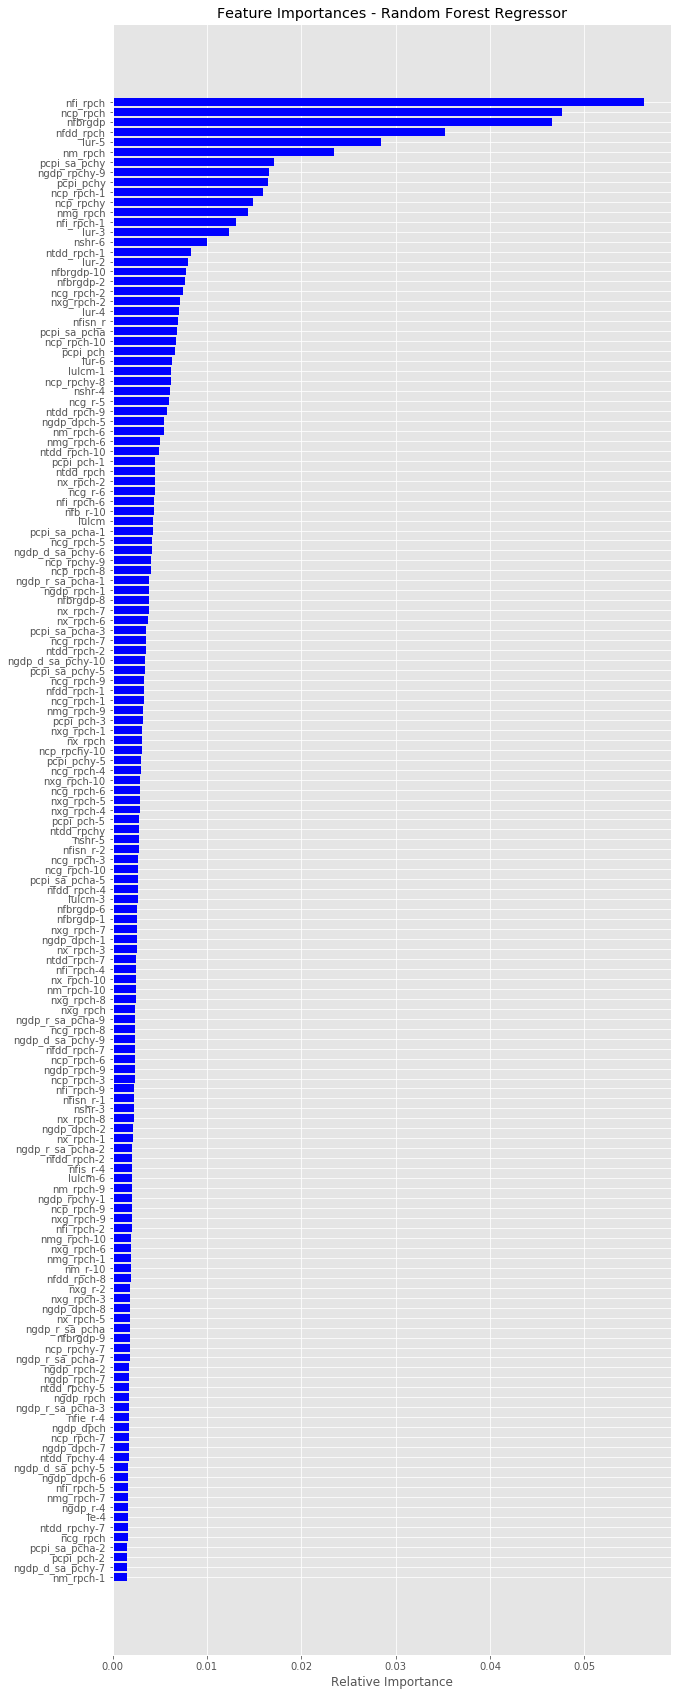

In [37]:
# Variable Importance
# i = 20

importances =  rfr.feature_importances_
top_features = []

imp_1 = sorted(np.array(importances), reverse = True)
sum = 0 
for i in range(len(imp_1)):
    sum = sum + imp_1[i]
    if sum > 0.8:
        n = i
        print("\n Top variables (> 80% variation): ", n+1, "\n Total variation explained: ", sum)
        break
                       
i = n

indices = np.argsort(importances)[-(i+1):]
 
print("Top features: ")

features = X_train.columns

top_features = features[indices]
top_features

plt.figure(figsize=(10,30))
plt.title('Feature Importances - Random Forest Regressor')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [38]:
#  Important features

print("\n Total important variables: ", len(top_features))
print("\n Important features: \n")
top_features


 Total important variables:  149

 Important features: 



Index(['nm_rpch-1', 'ngdp_d_sa_pchy-7', 'pcpi_pch-2', 'pcpi_sa_pcha-2',
       'ncg_rpch', 'ntdd_rpchy-7', 'le-4', 'ngdp_r-4', 'nmg_rpch-7',
       'nfi_rpch-5',
       ...
       'ncp_rpch-1', 'pcpi_pchy', 'ngdp_rpchy-9', 'pcpi_sa_pchy', 'nm_rpch',
       'lur-5', 'nfdd_rpch', 'nfbrgdp', 'ncp_rpch', 'nfi_rpch'],
      dtype='object', length=149)

In [39]:
# Train & Test set with important features from random forest

X_train_random_forest = X_train[top_features]
X_train_random_forest.shape

X_test_random_forest = X_test[top_features]
X_test_random_forest.shape

(97, 149)

(48, 149)

## LSTM

In [40]:
# Reshaping the training and test sets
X_train_1 = np.array(X_train_random_forest).reshape(X_train_random_forest.shape[0], X_train_random_forest.shape[1],1)
print("training set reshaped:", X_train_1.shape)

X_test_1 = np.array(X_test_random_forest).reshape(X_test_random_forest.shape[0], X_test_random_forest.shape[1],1)
print("test set reshaped:", X_test_1.shape)

training set reshaped: (97, 149, 1)
test set reshaped: (48, 149, 1)


In [41]:
import wandb
from keras.layers import LSTM
from wandb.keras import WandbCallback

In [42]:
#wandb.init(project='IMF')

In [43]:
sweep_config = {
    'method': 'grid',
    'metric': {
      'name': 'val_loss',
      'goal': 'minimize'   
    },
    'parameters': {
                  'epochs': {'values': [10, 20, 40]},
                  'batch_size': {'values': [16, 32, 64]},
                  'nn_units': {'values': [16, 32, 64]},
                  'dout_rate': {'values': [0.0, 0.2, 0.4, 0.6]}
    }
}

In [44]:
sweepid = wandb.sweep(sweep_config)

Create sweep with ID: 78fkzlsk
Sweep URL: https://app.wandb.ai/fiscal-forcast/IMF/sweeps/78fkzlsk


In [47]:
def train():
    
    # Specify the hyperparameter to be tuned along with
    # an initial value
    config_defaults = {
        'epochs': 10,
        'batch_size': 16,
        'nn_units': 16,
        'dout_rate': 0.0
    }
    
    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model
    model = Sequential()
    model.add(LSTM(units = config.nn_units, return_sequences = True, input_shape = (X_train_1.shape[1], 1)))
    model.add(Dropout(config.dout_rate))
    model.add(LSTM(units = config.nn_units, return_sequences = True))
    model.add(Dropout(config.dout_rate))
    model.add(LSTM(units = config.nn_units, return_sequences = True))
    model.add(Dropout(config.dout_rate))
    model.add(LSTM(units = config.nn_units, return_sequences = True))
    #model.add(Dropout(0.2))
    model.add(LSTM(units = config.nn_units, return_sequences = True))
    #model.add(Dropout(0.2))
    model.add(LSTM(units = config.nn_units, return_sequences = True))
    #model.add(Dropout(0.2))
    model.add(LSTM(units = config.nn_units))
    model.add(Dense(units = 1, activation='relu'))
    
    # Complie the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mse'])
    
    # Train the model
    model.fit(X_train_1, y_train, epochs = config.epochs, batch_size = config.batch_size, 
              validation_split = 0.3, callbacks=[WandbCallback()])

In [48]:
wandb.agent(sweepid, function=train)

wandb: Agent Starting Run: 08uegvbk with config:
	batch_size: 16
	nn_units: 32
	epochs: 10
	dout_rate: 0
wandb: Agent Started Run: 08uegvbk


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 8s 119ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 3s 41ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 3s 39ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 3s 39ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 3s 38ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/10
67/67 [==============================] - 3s 38ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/10
67/67 [==============================] - 3s 37ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/10

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 93ms/step - loss: 17.5952 - mse: 17.5952 - val_loss: 6.3653 - val_mse: 6.3653
Epoch 2/10
67/67 [==============================] - 3s 46ms/step - loss: 7.1583 - mse: 7.1583 - val_loss: 6.0974 - val_mse: 6.0974
Epoch 3/10
67/67 [==============================] - 3s 44ms/step - loss: 5.7199 - mse: 5.7199 - val_loss: 6.5350 - val_mse: 6.5350
Epoch 4/10
67/67 [==============================] - 3s 44ms/step - loss: 5.3486 - mse: 5.3486 - val_loss: 5.2170 - val_mse: 5.2170
Epoch 5/10
67/67 [==============================] - 3s 44ms/step - loss: 5.3152 - mse: 5.3152 - val_loss: 5.1233 - val_mse: 5.1233
Epoch 6/10
67/67 [==============================] - 3s 44ms/step - loss: 5.2814 - mse: 5.2814 - val_loss: 5.2572 - val_mse: 5.2572
Epoch 7/10
67/67 [==============================] - 3s 44ms/step - loss: 5.2591 - mse: 5.2592 - val_loss: 5.4915 - val_mse: 5.4915
Epoch 8/10
67/67 [===================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 89ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 3s 42ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 3s 41ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 3s 41ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/20
67/67 [==============================] - 3s 39ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/20
67/67 [==============================] - 3s 38ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/20
67/67 [==============================] - 3s 38ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/20


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 88ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 3s 42ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 3s 40ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 3s 40ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/20
67/67 [==============================] - 3s 39ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/20
67/67 [==============================] - 3s 40ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/20
67/67 [==============================] - 3s 39ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/20


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 91ms/step - loss: 17.8125 - mse: 17.8125 - val_loss: 6.9546 - val_mse: 6.9546
Epoch 2/20
67/67 [==============================] - 3s 45ms/step - loss: 7.6474 - mse: 7.6474 - val_loss: 5.9079 - val_mse: 5.9079
Epoch 3/20
67/67 [==============================] - 3s 44ms/step - loss: 5.7698 - mse: 5.7698 - val_loss: 6.7350 - val_mse: 6.7350
Epoch 4/20
67/67 [==============================] - 3s 43ms/step - loss: 5.3874 - mse: 5.3874 - val_loss: 5.2682 - val_mse: 5.2682
Epoch 5/20
67/67 [==============================] - 3s 44ms/step - loss: 5.3168 - mse: 5.3168 - val_loss: 5.1102 - val_mse: 5.1102
Epoch 6/20
67/67 [==============================] - 3s 44ms/step - loss: 5.2887 - mse: 5.2887 - val_loss: 5.2181 - val_mse: 5.2181
Epoch 7/20
67/67 [==============================] - 3s 43ms/step - loss: 5.2634 - mse: 5.2634 - val_loss: 5.4588 - val_mse: 5.4588
Epoch 8/20
67/67 [===================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 87ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/40
67/67 [==============================] - 3s 40ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/40
67/67 [==============================] - 3s 39ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/40
67/67 [==============================] - 3s 38ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/40
67/67 [==============================] - 3s 38ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/40
67/67 [==============================] - 3s 38ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/40
67/67 [==============================] - 2s 37ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/40


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 87ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/40
64/67 [===========================>..] - ETA: 0s - loss: 18.8008 - mse: 18.8008

wandb: Network error resolved after 0:00:28.396461, resuming normal operation.


67/67 [==============================] - 3s 42ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/40
67/67 [==============================] - 3s 41ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/40
67/67 [==============================] - 3s 39ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/40
67/67 [==============================] - 3s 39ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/40
67/67 [==============================] - 3s 39ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/40
67/67 [==============================] - 3s 38ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/40
67/67 [==============================] - 3s 38ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 9/40
67/67 [==============================] - 3s 38ms/step -

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 89ms/step - loss: 17.5952 - mse: 17.5952 - val_loss: 6.3653 - val_mse: 6.3653
Epoch 2/40
67/67 [==============================] - 3s 44ms/step - loss: 7.1583 - mse: 7.1583 - val_loss: 6.0974 - val_mse: 6.0974
Epoch 3/40
67/67 [==============================] - 3s 43ms/step - loss: 5.7199 - mse: 5.7199 - val_loss: 6.5350 - val_mse: 6.5350
Epoch 4/40
67/67 [==============================] - 3s 43ms/step - loss: 5.3486 - mse: 5.3486 - val_loss: 5.2170 - val_mse: 5.2170
Epoch 5/40
67/67 [==============================] - 3s 43ms/step - loss: 5.3152 - mse: 5.3152 - val_loss: 5.1233 - val_mse: 5.1233
Epoch 6/40
67/67 [==============================] - 3s 43ms/step - loss: 5.2814 - mse: 5.2814 - val_loss: 5.2572 - val_mse: 5.2572
Epoch 7/40
67/67 [==============================] - 3s 43ms/step - loss: 5.2591 - mse: 5.2592 - val_loss: 5.4915 - val_mse: 5.4915
Epoch 8/40
67/67 [===================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 88ms/step - loss: 19.1050 - mse: 19.1050 - val_loss: 12.9760 - val_mse: 12.9760
Epoch 2/10
67/67 [==============================] - 3s 37ms/step - loss: 18.6817 - mse: 18.6817 - val_loss: 12.3221 - val_mse: 12.3221
Epoch 3/10
67/67 [==============================] - 2s 36ms/step - loss: 17.5423 - mse: 17.5423 - val_loss: 10.5768 - val_mse: 10.5768
Epoch 4/10
67/67 [==============================] - 2s 36ms/step - loss: 14.5932 - mse: 14.5932 - val_loss: 8.1905 - val_mse: 8.1905
Epoch 5/10
67/67 [==============================] - 2s 36ms/step - loss: 11.5390 - mse: 11.5390 - val_loss: 6.4787 - val_mse: 6.4787
Epoch 6/10
67/67 [==============================] - 2s 35ms/step - loss: 9.1959 - mse: 9.1959 - val_loss: 5.4710 - val_mse: 5.4710
Epoch 7/10
67/67 [==============================] - 2s 35ms/step - loss: 7.6652 - mse: 7.6652 - val_loss: 4.9542 - val_mse: 4.9542
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 89ms/step - loss: 18.6422 - mse: 18.6422 - val_loss: 11.3038 - val_mse: 11.3038
Epoch 2/10
67/67 [==============================] - 3s 41ms/step - loss: 14.7226 - mse: 14.7226 - val_loss: 5.9795 - val_mse: 5.9795
Epoch 3/10
67/67 [==============================] - 3s 41ms/step - loss: 7.5723 - mse: 7.5723 - val_loss: 4.7959 - val_mse: 4.7959
Epoch 4/10
67/67 [==============================] - 3s 40ms/step - loss: 5.4199 - mse: 5.4199 - val_loss: 5.4483 - val_mse: 5.4483
Epoch 5/10
67/67 [==============================] - 3s 40ms/step - loss: 5.2092 - mse: 5.2092 - val_loss: 6.0471 - val_mse: 6.0471
Epoch 6/10
67/67 [==============================] - 3s 39ms/step - loss: 5.3409 - mse: 5.3409 - val_loss: 6.0806 - val_mse: 6.0806
Epoch 7/10
67/67 [==============================] - 3s 39ms/step - loss: 5.3638 - mse: 5.3638 - val_loss: 6.0076 - val_mse: 6.0076
Epoch 8/10
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 96ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 3s 48ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 3s 47ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 3s 47ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 3s 45ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/10
67/67 [==============================] - 3s 45ms/step - loss: 18.9079 - mse: 18.9079 - val_loss: 11.4360 - val_mse: 11.4360
Epoch 7/10
67/67 [==============================] - 3s 45ms/step - loss: 11.2962 - mse: 11.2962 - val_loss: 6.0035 - val_mse: 6.0035
Epoch 8/10
67

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 89ms/step - loss: 19.1050 - mse: 19.1050 - val_loss: 12.9760 - val_mse: 12.9760
Epoch 2/20
67/67 [==============================] - 3s 41ms/step - loss: 18.6817 - mse: 18.6817 - val_loss: 12.3221 - val_mse: 12.3221
Epoch 3/20
67/67 [==============================] - 3s 41ms/step - loss: 17.5423 - mse: 17.5423 - val_loss: 10.5768 - val_mse: 10.5768
Epoch 4/20
67/67 [==============================] - 3s 38ms/step - loss: 14.5932 - mse: 14.5932 - val_loss: 8.1905 - val_mse: 8.1905
Epoch 5/20
67/67 [==============================] - 3s 38ms/step - loss: 11.5390 - mse: 11.5390 - val_loss: 6.4787 - val_mse: 6.4787
Epoch 6/20
67/67 [==============================] - 2s 37ms/step - loss: 9.1959 - mse: 9.1959 - val_loss: 5.4710 - val_mse: 5.4710
Epoch 7/20
67/67 [==============================] - 2s 37ms/step - loss: 7.6652 - mse: 7.6652 - val_loss: 4.9542 - val_mse: 4.9542
Epoch 8/20
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 90ms/step - loss: 18.6422 - mse: 18.6422 - val_loss: 11.3038 - val_mse: 11.3038
Epoch 2/20
67/67 [==============================] - 3s 42ms/step - loss: 14.7192 - mse: 14.7192 - val_loss: 5.9695 - val_mse: 5.9695
Epoch 3/20
67/67 [==============================] - 3s 40ms/step - loss: 7.5615 - mse: 7.5615 - val_loss: 4.7967 - val_mse: 4.7967
Epoch 4/20
67/67 [==============================] - 3s 40ms/step - loss: 5.4186 - mse: 5.4186 - val_loss: 5.4490 - val_mse: 5.4490
Epoch 5/20
67/67 [==============================] - 3s 39ms/step - loss: 5.2094 - mse: 5.2094 - val_loss: 6.0464 - val_mse: 6.0464
Epoch 6/20
67/67 [==============================] - 3s 39ms/step - loss: 5.3407 - mse: 5.3407 - val_loss: 6.0796 - val_mse: 6.0796
Epoch 7/20
67/67 [==============================] - 3s 39ms/step - loss: 5.3636 - mse: 5.3636 - val_loss: 6.0069 - val_mse: 6.0069
Epoch 8/20
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 94ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 3s 46ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 3s 45ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 3s 45ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/20
67/67 [==============================] - 3s 45ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/20
67/67 [==============================] - 3s 44ms/step - loss: 18.9079 - mse: 18.9079 - val_loss: 11.4360 - val_mse: 11.4360
Epoch 7/20
67/67 [==============================] - 3s 44ms/step - loss: 11.2962 - mse: 11.2962 - val_loss: 6.0035 - val_mse: 6.0035
Epoch 8/20
67

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 89ms/step - loss: 19.1050 - mse: 19.1050 - val_loss: 12.9760 - val_mse: 12.9760
Epoch 2/40
67/67 [==============================] - 3s 41ms/step - loss: 18.6817 - mse: 18.6817 - val_loss: 12.3221 - val_mse: 12.3221
Epoch 3/40
67/67 [==============================] - 3s 39ms/step - loss: 17.5423 - mse: 17.5423 - val_loss: 10.5768 - val_mse: 10.5768
Epoch 4/40
67/67 [==============================] - 3s 39ms/step - loss: 14.5932 - mse: 14.5932 - val_loss: 8.1905 - val_mse: 8.1905
Epoch 5/40
67/67 [==============================] - 3s 38ms/step - loss: 11.5390 - mse: 11.5390 - val_loss: 6.4787 - val_mse: 6.4787
Epoch 6/40
67/67 [==============================] - 3s 38ms/step - loss: 9.1959 - mse: 9.1959 - val_loss: 5.4710 - val_mse: 5.4710
Epoch 7/40
67/67 [==============================] - 3s 38ms/step - loss: 7.6652 - mse: 7.6652 - val_loss: 4.9542 - val_mse: 4.9542
Epoch 8/40
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 88ms/step - loss: 18.7500 - mse: 18.7500 - val_loss: 11.6912 - val_mse: 11.6912
Epoch 2/40
67/67 [==============================] - 3s 43ms/step - loss: 15.5114 - mse: 15.5114 - val_loss: 6.5043 - val_mse: 6.5043
Epoch 3/40
67/67 [==============================] - 3s 42ms/step - loss: 8.1381 - mse: 8.1381 - val_loss: 4.7661 - val_mse: 4.7661
Epoch 4/40
67/67 [==============================] - 3s 41ms/step - loss: 5.4945 - mse: 5.4945 - val_loss: 5.4072 - val_mse: 5.4072
Epoch 5/40
67/67 [==============================] - 3s 40ms/step - loss: 5.2011 - mse: 5.2011 - val_loss: 6.0803 - val_mse: 6.0803
Epoch 6/40
67/67 [==============================] - 3s 39ms/step - loss: 5.3514 - mse: 5.3514 - val_loss: 6.1227 - val_mse: 6.1227
Epoch 7/40
67/67 [==============================] - 3s 38ms/step - loss: 5.3733 - mse: 5.3733 - val_loss: 6.0325 - val_mse: 6.0325
Epoch 8/40
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 92ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/40
67/67 [==============================] - 3s 44ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/40
67/67 [==============================] - 3s 43ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/40
67/67 [==============================] - 3s 43ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/40
67/67 [==============================] - 3s 42ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/40
67/67 [==============================] - 3s 42ms/step - loss: 18.9045 - mse: 18.9045 - val_loss: 11.3918 - val_mse: 11.3918
Epoch 7/40
67/67 [==============================] - 3s 42ms/step - loss: 11.1606 - mse: 11.1606 - val_loss: 6.1023 - val_mse: 6.1023
Epoch 8/40
67

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 88ms/step - loss: 19.0577 - mse: 19.0577 - val_loss: 12.8535 - val_mse: 12.8535
Epoch 2/10
67/67 [==============================] - 3s 40ms/step - loss: 18.4476 - mse: 18.4476 - val_loss: 11.9912 - val_mse: 11.9912
Epoch 3/10
67/67 [==============================] - 2s 37ms/step - loss: 16.9803 - mse: 16.9803 - val_loss: 9.9146 - val_mse: 9.9146
Epoch 4/10
67/67 [==============================] - 2s 37ms/step - loss: 13.7060 - mse: 13.7060 - val_loss: 7.6394 - val_mse: 7.6394
Epoch 5/10
67/67 [==============================] - 2s 36ms/step - loss: 10.8512 - mse: 10.8512 - val_loss: 6.1768 - val_mse: 6.1768
Epoch 6/10
67/67 [==============================] - 2s 36ms/step - loss: 8.7643 - mse: 8.7643 - val_loss: 5.3151 - val_mse: 5.3151
Epoch 7/10
67/67 [==============================] - 2s 36ms/step - loss: 7.3926 - mse: 7.3926 - val_loss: 4.8932 - val_mse: 4.8932
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 89ms/step - loss: 18.7657 - mse: 18.7657 - val_loss: 11.7468 - val_mse: 11.7468
Epoch 2/10
67/67 [==============================] - 3s 41ms/step - loss: 15.6210 - mse: 15.6210 - val_loss: 6.5425 - val_mse: 6.5425
Epoch 3/10
67/67 [==============================] - 3s 41ms/step - loss: 8.1909 - mse: 8.1909 - val_loss: 4.7619 - val_mse: 4.7619
Epoch 4/10
67/67 [==============================] - 3s 40ms/step - loss: 5.5133 - mse: 5.5133 - val_loss: 5.4120 - val_mse: 5.4120
Epoch 5/10
67/67 [==============================] - 3s 39ms/step - loss: 5.2016 - mse: 5.2016 - val_loss: 6.1162 - val_mse: 6.1162
Epoch 6/10
67/67 [==============================] - 3s 39ms/step - loss: 5.3621 - mse: 5.3621 - val_loss: 6.1398 - val_mse: 6.1398
Epoch 7/10
67/67 [==============================] - 3s 39ms/step - loss: 5.3746 - mse: 5.3746 - val_loss: 6.0282 - val_mse: 6.0282
Epoch 8/10
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 95ms/step - loss: 18.0921 - mse: 18.0921 - val_loss: 7.4957 - val_mse: 7.4957
Epoch 2/10
67/67 [==============================] - 3s 48ms/step - loss: 7.2836 - mse: 7.2836 - val_loss: 6.1509 - val_mse: 6.1509
Epoch 3/10
67/67 [==============================] - 3s 46ms/step - loss: 5.4039 - mse: 5.4039 - val_loss: 6.0110 - val_mse: 6.0110
Epoch 4/10
67/67 [==============================] - 3s 45ms/step - loss: 5.3514 - mse: 5.3514 - val_loss: 5.8196 - val_mse: 5.8196
Epoch 5/10
67/67 [==============================] - 3s 44ms/step - loss: 5.2845 - mse: 5.2845 - val_loss: 5.1016 - val_mse: 5.1016
Epoch 6/10
67/67 [==============================] - 3s 44ms/step - loss: 5.3095 - mse: 5.3095 - val_loss: 5.2026 - val_mse: 5.2026
Epoch 7/10
67/67 [==============================] - 3s 43ms/step - loss: 5.2421 - mse: 5.2421 - val_loss: 5.5182 - val_mse: 5.5182
Epoch 8/10
67/67 [===================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 94ms/step - loss: 19.0577 - mse: 19.0577 - val_loss: 12.8535 - val_mse: 12.8535
Epoch 2/20
67/67 [==============================] - 3s 42ms/step - loss: 18.4476 - mse: 18.4476 - val_loss: 11.9912 - val_mse: 11.9912
Epoch 3/20
67/67 [==============================] - 3s 39ms/step - loss: 16.9803 - mse: 16.9803 - val_loss: 9.9146 - val_mse: 9.9146
Epoch 4/20
67/67 [==============================] - 3s 38ms/step - loss: 13.7060 - mse: 13.7060 - val_loss: 7.6394 - val_mse: 7.6394
Epoch 5/20
67/67 [==============================] - 3s 38ms/step - loss: 10.8512 - mse: 10.8512 - val_loss: 6.1768 - val_mse: 6.1768
Epoch 6/20
67/67 [==============================] - 3s 38ms/step - loss: 8.7643 - mse: 8.7643 - val_loss: 5.3151 - val_mse: 5.3151
Epoch 7/20
67/67 [==============================] - 3s 38ms/step - loss: 7.3926 - mse: 7.3926 - val_loss: 4.8932 - val_mse: 4.8932
Epoch 8/20
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 88ms/step - loss: 18.6580 - mse: 18.6580 - val_loss: 11.3553 - val_mse: 11.3553
Epoch 2/20
67/67 [==============================] - 3s 40ms/step - loss: 14.8089 - mse: 14.8089 - val_loss: 5.9711 - val_mse: 5.9711
Epoch 3/20
67/67 [==============================] - 3s 40ms/step - loss: 7.5865 - mse: 7.5865 - val_loss: 4.7870 - val_mse: 4.7870
Epoch 4/20
67/67 [==============================] - 3s 39ms/step - loss: 5.4343 - mse: 5.4344 - val_loss: 5.4570 - val_mse: 5.4570
Epoch 5/20
67/67 [==============================] - 3s 39ms/step - loss: 5.2103 - mse: 5.2103 - val_loss: 6.0879 - val_mse: 6.0879
Epoch 6/20
67/67 [==============================] - 3s 39ms/step - loss: 5.3527 - mse: 5.3527 - val_loss: 6.1030 - val_mse: 6.1030
Epoch 7/20
67/67 [==============================] - 3s 39ms/step - loss: 5.3662 - mse: 5.3662 - val_loss: 6.0069 - val_mse: 6.0069
Epoch 8/20
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 94ms/step - loss: 18.3771 - mse: 18.3771 - val_loss: 8.8078 - val_mse: 8.8078
Epoch 2/20
67/67 [==============================] - 3s 46ms/step - loss: 8.3573 - mse: 8.3573 - val_loss: 5.7825 - val_mse: 5.7825
Epoch 3/20
67/67 [==============================] - 3s 45ms/step - loss: 5.2941 - mse: 5.2941 - val_loss: 6.2284 - val_mse: 6.2284
Epoch 4/20
67/67 [==============================] - 3s 45ms/step - loss: 5.4348 - mse: 5.4348 - val_loss: 5.9688 - val_mse: 5.9688
Epoch 5/20
67/67 [==============================] - 3s 44ms/step - loss: 5.2963 - mse: 5.2963 - val_loss: 5.0750 - val_mse: 5.0750
Epoch 6/20
67/67 [==============================] - 3s 44ms/step - loss: 5.3208 - mse: 5.3208 - val_loss: 5.1587 - val_mse: 5.1587
Epoch 7/20
67/67 [==============================] - 3s 44ms/step - loss: 5.2485 - mse: 5.2485 - val_loss: 5.4916 - val_mse: 5.4916
Epoch 8/20
67/67 [===================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 88ms/step - loss: 19.0577 - mse: 19.0577 - val_loss: 12.8535 - val_mse: 12.8535
Epoch 2/40
67/67 [==============================] - 3s 40ms/step - loss: 18.4476 - mse: 18.4476 - val_loss: 11.9912 - val_mse: 11.9912
Epoch 3/40
67/67 [==============================] - 3s 39ms/step - loss: 16.9803 - mse: 16.9803 - val_loss: 9.9146 - val_mse: 9.9146
Epoch 4/40
67/67 [==============================] - 3s 39ms/step - loss: 13.7060 - mse: 13.7060 - val_loss: 7.6394 - val_mse: 7.6394
Epoch 5/40
67/67 [==============================] - 3s 38ms/step - loss: 10.8512 - mse: 10.8512 - val_loss: 6.1768 - val_mse: 6.1768
Epoch 6/40
67/67 [==============================] - 3s 38ms/step - loss: 8.7643 - mse: 8.7643 - val_loss: 5.3151 - val_mse: 5.3151
Epoch 7/40
67/67 [==============================] - 3s 38ms/step - loss: 7.3926 - mse: 7.3926 - val_loss: 4.8932 - val_mse: 4.8932
Epoch 8/40
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 87ms/step - loss: 18.7657 - mse: 18.7657 - val_loss: 11.7468 - val_mse: 11.7468
Epoch 2/40
67/67 [==============================] - 3s 40ms/step - loss: 15.6210 - mse: 15.6210 - val_loss: 6.5425 - val_mse: 6.5425
Epoch 3/40
67/67 [==============================] - 3s 39ms/step - loss: 8.1909 - mse: 8.1909 - val_loss: 4.7619 - val_mse: 4.7619
Epoch 4/40
67/67 [==============================] - 3s 39ms/step - loss: 5.5133 - mse: 5.5133 - val_loss: 5.4097 - val_mse: 5.4097
Epoch 5/40
67/67 [==============================] - 3s 38ms/step - loss: 5.2011 - mse: 5.2011 - val_loss: 6.1149 - val_mse: 6.1149
Epoch 6/40
67/67 [==============================] - 3s 38ms/step - loss: 5.3618 - mse: 5.3618 - val_loss: 6.1402 - val_mse: 6.1402
Epoch 7/40
67/67 [==============================] - 3s 38ms/step - loss: 5.3749 - mse: 5.3749 - val_loss: 6.0291 - val_mse: 6.0291
Epoch 8/40
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 92ms/step - loss: 18.0921 - mse: 18.0921 - val_loss: 7.4957 - val_mse: 7.4957
Epoch 2/40
67/67 [==============================] - 3s 44ms/step - loss: 7.2836 - mse: 7.2836 - val_loss: 6.1509 - val_mse: 6.1509
Epoch 3/40
67/67 [==============================] - 3s 44ms/step - loss: 5.4039 - mse: 5.4039 - val_loss: 6.0110 - val_mse: 6.0110
Epoch 4/40
67/67 [==============================] - 3s 43ms/step - loss: 5.3514 - mse: 5.3514 - val_loss: 5.8196 - val_mse: 5.8196
Epoch 5/40
67/67 [==============================] - 3s 43ms/step - loss: 5.2845 - mse: 5.2845 - val_loss: 5.1016 - val_mse: 5.1016
Epoch 6/40
67/67 [==============================] - 3s 44ms/step - loss: 5.3095 - mse: 5.3095 - val_loss: 5.2026 - val_mse: 5.2026
Epoch 7/40
67/67 [==============================] - 3s 44ms/step - loss: 5.2421 - mse: 5.2421 - val_loss: 5.5182 - val_mse: 5.5182
Epoch 8/40
67/67 [===================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 86ms/step - loss: 18.9406 - mse: 18.9406 - val_loss: 12.6240 - val_mse: 12.6240
Epoch 2/10
67/67 [==============================] - 3s 39ms/step - loss: 17.9982 - mse: 17.9982 - val_loss: 11.2898 - val_mse: 11.2898
Epoch 3/10
67/67 [==============================] - 3s 41ms/step - loss: 15.8239 - mse: 15.8239 - val_loss: 8.7614 - val_mse: 8.7614
Epoch 4/10
67/67 [==============================] - 3s 40ms/step - loss: 12.3427 - mse: 12.3427 - val_loss: 6.9987 - val_mse: 6.9987
Epoch 5/10
67/67 [==============================] - 2s 36ms/step - loss: 10.0615 - mse: 10.0615 - val_loss: 5.8778 - val_mse: 5.8778
Epoch 6/10
67/67 [==============================] - 2s 36ms/step - loss: 8.3262 - mse: 8.3262 - val_loss: 5.1618 - val_mse: 5.1618
Epoch 7/10
67/67 [==============================] - 2s 35ms/step - loss: 7.0659 - mse: 7.0659 - val_loss: 4.8070 - val_mse: 4.8070
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 88ms/step - loss: 18.6279 - mse: 18.6279 - val_loss: 11.2442 - val_mse: 11.2442
Epoch 2/10
67/67 [==============================] - 3s 40ms/step - loss: 14.6932 - mse: 14.6932 - val_loss: 5.9015 - val_mse: 5.9015
Epoch 3/10
67/67 [==============================] - 3s 39ms/step - loss: 7.5813 - mse: 7.5813 - val_loss: 4.7780 - val_mse: 4.7780
Epoch 4/10
67/67 [==============================] - 3s 39ms/step - loss: 5.4502 - mse: 5.4502 - val_loss: 5.4915 - val_mse: 5.4915
Epoch 5/10
67/67 [==============================] - 3s 38ms/step - loss: 5.2163 - mse: 5.2163 - val_loss: 6.1735 - val_mse: 6.1735
Epoch 6/10
67/67 [==============================] - 3s 38ms/step - loss: 5.3774 - mse: 5.3774 - val_loss: 6.1472 - val_mse: 6.1472
Epoch 7/10
67/67 [==============================] - 3s 38ms/step - loss: 5.3700 - mse: 5.3700 - val_loss: 6.0017 - val_mse: 6.0017
Epoch 8/10
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 6s 95ms/step - loss: 18.0549 - mse: 18.0549 - val_loss: 7.3874 - val_mse: 7.3874
Epoch 2/10
67/67 [==============================] - 3s 47ms/step - loss: 7.1624 - mse: 7.1624 - val_loss: 6.2169 - val_mse: 6.2169
Epoch 3/10
67/67 [==============================] - 3s 47ms/step - loss: 5.4232 - mse: 5.4232 - val_loss: 5.9473 - val_mse: 5.9473
Epoch 4/10
67/67 [==============================] - 3s 47ms/step - loss: 5.3359 - mse: 5.3359 - val_loss: 5.7918 - val_mse: 5.7918
Epoch 5/10
67/67 [==============================] - 3s 45ms/step - loss: 5.2833 - mse: 5.2833 - val_loss: 5.1099 - val_mse: 5.1099
Epoch 6/10
67/67 [==============================] - 3s 44ms/step - loss: 5.3076 - mse: 5.3076 - val_loss: 5.2301 - val_mse: 5.2301
Epoch 7/10
67/67 [==============================] - 3s 44ms/step - loss: 5.2385 - mse: 5.2385 - val_loss: 5.5449 - val_mse: 5.5449
Epoch 8/10
67/67 [===================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 90ms/step - loss: 18.9406 - mse: 18.9406 - val_loss: 12.6240 - val_mse: 12.6240
Epoch 2/20
67/67 [==============================] - 3s 42ms/step - loss: 17.9982 - mse: 17.9982 - val_loss: 11.2898 - val_mse: 11.2898
Epoch 3/20
67/67 [==============================] - 3s 41ms/step - loss: 15.8239 - mse: 15.8239 - val_loss: 8.7614 - val_mse: 8.7614
Epoch 4/20
67/67 [==============================] - 3s 40ms/step - loss: 12.3427 - mse: 12.3427 - val_loss: 6.9987 - val_mse: 6.9987
Epoch 5/20
67/67 [==============================] - 3s 39ms/step - loss: 10.0615 - mse: 10.0615 - val_loss: 5.8778 - val_mse: 5.8778
Epoch 6/20
67/67 [==============================] - 3s 40ms/step - loss: 8.3262 - mse: 8.3262 - val_loss: 5.1618 - val_mse: 5.1618
Epoch 7/20
67/67 [==============================] - 3s 39ms/step - loss: 7.0659 - mse: 7.0659 - val_loss: 4.8070 - val_mse: 4.8070
Epoch 8/20
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 89ms/step - loss: 18.6698 - mse: 18.6698 - val_loss: 11.4668 - val_mse: 11.4668
Epoch 2/20
67/67 [==============================] - 3s 40ms/step - loss: 15.1223 - mse: 15.1223 - val_loss: 6.1571 - val_mse: 6.1571
Epoch 3/20
67/67 [==============================] - 3s 39ms/step - loss: 7.8619 - mse: 7.8619 - val_loss: 4.7651 - val_mse: 4.7652
Epoch 4/20
67/67 [==============================] - 3s 39ms/step - loss: 5.4926 - mse: 5.4926 - val_loss: 5.4668 - val_mse: 5.4668
Epoch 5/20
67/67 [==============================] - 3s 38ms/step - loss: 5.2113 - mse: 5.2113 - val_loss: 6.1937 - val_mse: 6.1937
Epoch 6/20
67/67 [==============================] - 3s 39ms/step - loss: 5.3843 - mse: 5.3843 - val_loss: 6.1700 - val_mse: 6.1700
Epoch 7/20
67/67 [==============================] - 3s 38ms/step - loss: 5.3751 - mse: 5.3751 - val_loss: 6.0114 - val_mse: 6.0114
Epoch 8/20
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 6s 93ms/step - loss: 18.3504 - mse: 18.3504 - val_loss: 8.7762 - val_mse: 8.7762
Epoch 2/20
67/67 [==============================] - 3s 46ms/step - loss: 8.2905 - mse: 8.2905 - val_loss: 5.8337 - val_mse: 5.8337
Epoch 3/20
67/67 [==============================] - 3s 45ms/step - loss: 5.3084 - mse: 5.3084 - val_loss: 6.1820 - val_mse: 6.1820
Epoch 4/20
67/67 [==============================] - 3s 45ms/step - loss: 5.4210 - mse: 5.4210 - val_loss: 5.9501 - val_mse: 5.9501
Epoch 5/20
67/67 [==============================] - 3s 45ms/step - loss: 5.2952 - mse: 5.2952 - val_loss: 5.0827 - val_mse: 5.0827
Epoch 6/20
67/67 [==============================] - 3s 45ms/step - loss: 5.3182 - mse: 5.3182 - val_loss: 5.1829 - val_mse: 5.1829
Epoch 7/20
67/67 [==============================] - 3s 45ms/step - loss: 5.2437 - mse: 5.2437 - val_loss: 5.5254 - val_mse: 5.5254
Epoch 8/20
67/67 [===================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 88ms/step - loss: 18.9406 - mse: 18.9406 - val_loss: 12.6240 - val_mse: 12.6240
Epoch 2/40
67/67 [==============================] - 3s 40ms/step - loss: 17.9982 - mse: 17.9982 - val_loss: 11.2898 - val_mse: 11.2898
Epoch 3/40
67/67 [==============================] - 3s 39ms/step - loss: 15.8239 - mse: 15.8239 - val_loss: 8.7614 - val_mse: 8.7614
Epoch 4/40
67/67 [==============================] - 3s 38ms/step - loss: 12.3427 - mse: 12.3427 - val_loss: 6.9987 - val_mse: 6.9987
Epoch 5/40
67/67 [==============================] - 3s 38ms/step - loss: 10.0615 - mse: 10.0615 - val_loss: 5.8778 - val_mse: 5.8778
Epoch 6/40
67/67 [==============================] - 3s 38ms/step - loss: 8.3262 - mse: 8.3262 - val_loss: 5.1618 - val_mse: 5.1618
Epoch 7/40
67/67 [==============================] - 3s 38ms/step - loss: 7.0659 - mse: 7.0659 - val_loss: 4.8070 - val_mse: 4.8070
Epoch 8/40
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 88ms/step - loss: 18.6698 - mse: 18.6698 - val_loss: 11.4668 - val_mse: 11.4668
Epoch 2/40
67/67 [==============================] - 3s 40ms/step - loss: 15.1368 - mse: 15.1368 - val_loss: 6.1713 - val_mse: 6.1713
Epoch 3/40
67/67 [==============================] - 3s 38ms/step - loss: 7.8776 - mse: 7.8776 - val_loss: 4.7644 - val_mse: 4.7644
Epoch 4/40
67/67 [==============================] - 3s 38ms/step - loss: 5.4959 - mse: 5.4959 - val_loss: 5.4642 - val_mse: 5.4642
Epoch 5/40
67/67 [==============================] - 2s 37ms/step - loss: 5.2107 - mse: 5.2107 - val_loss: 6.1943 - val_mse: 6.1943
Epoch 6/40
67/67 [==============================] - 2s 37ms/step - loss: 5.3846 - mse: 5.3846 - val_loss: 6.1720 - val_mse: 6.1720
Epoch 7/40
67/67 [==============================] - 2s 37ms/step - loss: 5.3756 - mse: 5.3756 - val_loss: 6.0130 - val_mse: 6.0130
Epoch 8/40
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 6s 92ms/step - loss: 18.0549 - mse: 18.0549 - val_loss: 7.3874 - val_mse: 7.3874
Epoch 2/40
67/67 [==============================] - 3s 44ms/step - loss: 7.1624 - mse: 7.1624 - val_loss: 6.2169 - val_mse: 6.2169
Epoch 3/40
67/67 [==============================] - 3s 44ms/step - loss: 5.4232 - mse: 5.4232 - val_loss: 5.9473 - val_mse: 5.9473
Epoch 4/40
67/67 [==============================] - 3s 44ms/step - loss: 5.3359 - mse: 5.3359 - val_loss: 5.7918 - val_mse: 5.7918
Epoch 5/40
67/67 [==============================] - 3s 47ms/step - loss: 5.2833 - mse: 5.2833 - val_loss: 5.1099 - val_mse: 5.1099
Epoch 6/40
67/67 [==============================] - 3s 43ms/step - loss: 5.3076 - mse: 5.3076 - val_loss: 5.2301 - val_mse: 5.2301
Epoch 7/40
67/67 [==============================] - 3s 42ms/step - loss: 5.2385 - mse: 5.2385 - val_loss: 5.5449 - val_mse: 5.5449
Epoch 8/40
67/67 [===================

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 69ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 1s 22ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/10
67/67 [==============================] - 1s 22ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/10
67/67 [==============================] - 1s 22ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 71ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/10
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/10
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 76ms/step - loss: 18.9166 - mse: 18.9166 - val_loss: 11.5102 - val_mse: 11.5102
Epoch 2/10
67/67 [==============================] - 2s 31ms/step - loss: 15.5594 - mse: 15.5594 - val_loss: 5.6161 - val_mse: 5.6161
Epoch 3/10
67/67 [==============================] - 2s 30ms/step - loss: 7.5322 - mse: 7.5322 - val_loss: 5.1218 - val_mse: 5.1218
Epoch 4/10
67/67 [==============================] - 2s 30ms/step - loss: 5.2277 - mse: 5.2277 - val_loss: 6.9330 - val_mse: 6.9330
Epoch 5/10
67/67 [==============================] - 2s 30ms/step - loss: 5.7056 - mse: 5.7056 - val_loss: 7.1325 - val_mse: 7.1325
Epoch 6/10
67/67 [==============================] - 2s 30ms/step - loss: 5.6438 - mse: 5.6438 - val_loss: 6.0500 - val_mse: 6.0500
Epoch 7/10
67/67 [==============================] - 2s 30ms/step - loss: 5.2734 - mse: 5.2734 - val_loss: 5.2428 - val_mse: 5.2428
Epoch 8/10
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 71ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/20
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/20
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/20
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/20


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 72ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 2s 26ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 2s 26ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 2s 26ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/20
67/67 [==============================] - 2s 26ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/20
67/67 [==============================] - 2s 26ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/20
67/67 [==============================] - 2s 26ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/20


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 79ms/step - loss: 18.8417 - mse: 18.8417 - val_loss: 10.8224 - val_mse: 10.8224
Epoch 2/20
67/67 [==============================] - 2s 30ms/step - loss: 14.2418 - mse: 14.2418 - val_loss: 5.0948 - val_mse: 5.0948
Epoch 3/20
67/67 [==============================] - 2s 30ms/step - loss: 6.7119 - mse: 6.7119 - val_loss: 5.4092 - val_mse: 5.4092
Epoch 4/20
67/67 [==============================] - 2s 29ms/step - loss: 5.2394 - mse: 5.2394 - val_loss: 6.8075 - val_mse: 6.8075
Epoch 5/20
67/67 [==============================] - 2s 29ms/step - loss: 5.6322 - mse: 5.6322 - val_loss: 6.8649 - val_mse: 6.8649
Epoch 6/20
67/67 [==============================] - 2s 29ms/step - loss: 5.5388 - mse: 5.5388 - val_loss: 5.8975 - val_mse: 5.8975
Epoch 7/20
67/67 [==============================] - 2s 29ms/step - loss: 5.2502 - mse: 5.2502 - val_loss: 5.1989 - val_mse: 5.1989
Epoch 8/20
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 70ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/40
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/40
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/40
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/40
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/40
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/40
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/40


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 71ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/40
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/40
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/40
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/40
67/67 [==============================] - 2s 25ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/40
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/40
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/40


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 74ms/step - loss: 18.8471 - mse: 18.8471 - val_loss: 11.1923 - val_mse: 11.1923
Epoch 2/40
67/67 [==============================] - 2s 29ms/step - loss: 14.9677 - mse: 14.9677 - val_loss: 5.3719 - val_mse: 5.3719
Epoch 3/40
67/67 [==============================] - 2s 29ms/step - loss: 7.1660 - mse: 7.1660 - val_loss: 5.2411 - val_mse: 5.2411
Epoch 4/40
67/67 [==============================] - 2s 28ms/step - loss: 5.2279 - mse: 5.2279 - val_loss: 6.9156 - val_mse: 6.9156
Epoch 5/40
67/67 [==============================] - 2s 28ms/step - loss: 5.6893 - mse: 5.6893 - val_loss: 7.0391 - val_mse: 7.0391
Epoch 6/40
67/67 [==============================] - 2s 28ms/step - loss: 5.6052 - mse: 5.6052 - val_loss: 5.9882 - val_mse: 5.9882
Epoch 7/40
67/67 [==============================] - 2s 28ms/step - loss: 5.2623 - mse: 5.2623 - val_loss: 5.2116 - val_mse: 5.2116
Epoch 8/40
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 71ms/step - loss: 19.1214 - mse: 19.1214 - val_loss: 13.0323 - val_mse: 13.0323
Epoch 2/10
67/67 [==============================] - 2s 24ms/step - loss: 18.9206 - mse: 18.9206 - val_loss: 12.7544 - val_mse: 12.7544
Epoch 3/10
67/67 [==============================] - 2s 24ms/step - loss: 18.5298 - mse: 18.5298 - val_loss: 12.2506 - val_mse: 12.2506
Epoch 4/10
67/67 [==============================] - 2s 24ms/step - loss: 17.7416 - mse: 17.7416 - val_loss: 11.3584 - val_mse: 11.3584
Epoch 5/10
67/67 [==============================] - 2s 23ms/step - loss: 16.4768 - mse: 16.4768 - val_loss: 10.0233 - val_mse: 10.0233
Epoch 6/10
67/67 [==============================] - 2s 23ms/step - loss: 14.5683 - mse: 14.5683 - val_loss: 8.5872 - val_mse: 8.5872
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 12.6709 - mse: 12.6709 - val_loss: 7.3218 - val_mse: 7.3218
Epoch 8/10
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 72ms/step - loss: 19.0148 - mse: 19.0148 - val_loss: 12.5563 - val_mse: 12.5563
Epoch 2/10
67/67 [==============================] - 2s 26ms/step - loss: 18.0795 - mse: 18.0795 - val_loss: 11.0021 - val_mse: 11.0021
Epoch 3/10
67/67 [==============================] - 2s 25ms/step - loss: 15.5607 - mse: 15.5607 - val_loss: 7.5386 - val_mse: 7.5386
Epoch 4/10
67/67 [==============================] - 2s 25ms/step - loss: 10.3985 - mse: 10.3985 - val_loss: 5.0993 - val_mse: 5.0993
Epoch 5/10
67/67 [==============================] - 2s 24ms/step - loss: 6.7067 - mse: 6.7067 - val_loss: 4.7860 - val_mse: 4.7860
Epoch 6/10
67/67 [==============================] - 2s 25ms/step - loss: 5.4859 - mse: 5.4859 - val_loss: 5.2645 - val_mse: 5.2645
Epoch 7/10
67/67 [==============================] - 2s 25ms/step - loss: 5.3510 - mse: 5.3510 - val_loss: 5.8050 - val_mse: 5.8050
Epoch 8/10
67/67 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 78ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 2s 31ms/step - loss: 19.1149 - mse: 19.1149 - val_loss: 12.7998 - val_mse: 12.7998
Epoch 3/10
67/67 [==============================] - 2s 30ms/step - loss: 18.2884 - mse: 18.2884 - val_loss: 10.3125 - val_mse: 10.3125
Epoch 4/10
67/67 [==============================] - 2s 30ms/step - loss: 13.3587 - mse: 13.3587 - val_loss: 4.9013 - val_mse: 4.9013
Epoch 5/10
67/67 [==============================] - 2s 29ms/step - loss: 6.1343 - mse: 6.1343 - val_loss: 6.1451 - val_mse: 6.1451
Epoch 6/10
67/67 [==============================] - 2s 30ms/step - loss: 5.7492 - mse: 5.7492 - val_loss: 7.4622 - val_mse: 7.4622
Epoch 7/10
67/67 [==============================] - 2s 30ms/step - loss: 5.8306 - mse: 5.8306 - val_loss: 6.3979 - val_mse: 6.3979
Epoch 8/10
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 72ms/step - loss: 19.1218 - mse: 19.1218 - val_loss: 13.0472 - val_mse: 13.0472
Epoch 2/20
67/67 [==============================] - 2s 25ms/step - loss: 18.9453 - mse: 18.9453 - val_loss: 12.7912 - val_mse: 12.7912
Epoch 3/20
67/67 [==============================] - 2s 25ms/step - loss: 18.5828 - mse: 18.5828 - val_loss: 12.3221 - val_mse: 12.3221
Epoch 4/20
67/67 [==============================] - 2s 24ms/step - loss: 17.8507 - mse: 17.8507 - val_loss: 11.4838 - val_mse: 11.4838
Epoch 5/20
67/67 [==============================] - 2s 25ms/step - loss: 16.6532 - mse: 16.6532 - val_loss: 10.1757 - val_mse: 10.1757
Epoch 6/20
67/67 [==============================] - 2s 24ms/step - loss: 14.7735 - mse: 14.7735 - val_loss: 8.7279 - val_mse: 8.7279
Epoch 7/20
67/67 [==============================] - 2s 24ms/step - loss: 12.8658 - mse: 12.8658 - val_loss: 7.4321 - val_mse: 7.4321
Epoch 8/20
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 73ms/step - loss: 18.9784 - mse: 18.9784 - val_loss: 12.3931 - val_mse: 12.3931
Epoch 2/20
67/67 [==============================] - 2s 26ms/step - loss: 17.7927 - mse: 17.7927 - val_loss: 10.4567 - val_mse: 10.4567
Epoch 3/20
67/67 [==============================] - 2s 26ms/step - loss: 14.6991 - mse: 14.6991 - val_loss: 6.8239 - val_mse: 6.8239
Epoch 4/20
67/67 [==============================] - 2s 26ms/step - loss: 9.4366 - mse: 9.4366 - val_loss: 4.9241 - val_mse: 4.9241
Epoch 5/20
67/67 [==============================] - 2s 25ms/step - loss: 6.3320 - mse: 6.3320 - val_loss: 4.8407 - val_mse: 4.8407
Epoch 6/20
67/67 [==============================] - 2s 26ms/step - loss: 5.3777 - mse: 5.3777 - val_loss: 5.3892 - val_mse: 5.3892
Epoch 7/20
67/67 [==============================] - 2s 26ms/step - loss: 5.3448 - mse: 5.3448 - val_loss: 5.9245 - val_mse: 5.9245
Epoch 8/20
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 76ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 2s 29ms/step - loss: 19.1149 - mse: 19.1149 - val_loss: 12.7926 - val_mse: 12.7926
Epoch 3/20
67/67 [==============================] - 2s 28ms/step - loss: 18.2640 - mse: 18.2640 - val_loss: 10.2120 - val_mse: 10.2120
Epoch 4/20
67/67 [==============================] - 2s 28ms/step - loss: 13.1809 - mse: 13.1809 - val_loss: 4.8807 - val_mse: 4.8807
Epoch 5/20
67/67 [==============================] - 2s 28ms/step - loss: 6.0954 - mse: 6.0954 - val_loss: 6.1277 - val_mse: 6.1277
Epoch 6/20
67/67 [==============================] - 2s 28ms/step - loss: 5.7354 - mse: 5.7354 - val_loss: 7.4424 - val_mse: 7.4424
Epoch 7/20
67/67 [==============================] - 2s 28ms/step - loss: 5.8234 - mse: 5.8234 - val_loss: 6.4103 - val_mse: 6.4103
Epoch 8/20
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 72ms/step - loss: 19.1214 - mse: 19.1214 - val_loss: 13.0323 - val_mse: 13.0323
Epoch 2/40
67/67 [==============================] - 2s 25ms/step - loss: 18.9206 - mse: 18.9206 - val_loss: 12.7544 - val_mse: 12.7544
Epoch 3/40
67/67 [==============================] - 2s 23ms/step - loss: 18.5298 - mse: 18.5298 - val_loss: 12.2506 - val_mse: 12.2506
Epoch 4/40
67/67 [==============================] - 2s 23ms/step - loss: 17.7416 - mse: 17.7416 - val_loss: 11.3584 - val_mse: 11.3584
Epoch 5/40
67/67 [==============================] - 2s 23ms/step - loss: 16.4768 - mse: 16.4768 - val_loss: 10.0233 - val_mse: 10.0233
Epoch 6/40
67/67 [==============================] - 2s 23ms/step - loss: 14.5683 - mse: 14.5683 - val_loss: 8.5872 - val_mse: 8.5872
Epoch 7/40
67/67 [==============================] - 2s 23ms/step - loss: 12.6709 - mse: 12.6709 - val_loss: 7.3218 - val_mse: 7.3218
Epoch 8/40
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 76ms/step - loss: 18.9784 - mse: 18.9784 - val_loss: 12.3931 - val_mse: 12.3931
Epoch 2/40
67/67 [==============================] - 2s 28ms/step - loss: 17.7927 - mse: 17.7927 - val_loss: 10.4567 - val_mse: 10.4567
Epoch 3/40
67/67 [==============================] - 2s 27ms/step - loss: 14.6991 - mse: 14.6991 - val_loss: 6.8239 - val_mse: 6.8239
Epoch 4/40
67/67 [==============================] - 2s 26ms/step - loss: 9.4366 - mse: 9.4366 - val_loss: 4.9241 - val_mse: 4.9241
Epoch 5/40
67/67 [==============================] - 2s 26ms/step - loss: 6.3320 - mse: 6.3320 - val_loss: 4.8407 - val_mse: 4.8407
Epoch 6/40
67/67 [==============================] - 2s 26ms/step - loss: 5.3777 - mse: 5.3777 - val_loss: 5.3892 - val_mse: 5.3892
Epoch 7/40
67/67 [==============================] - 2s 26ms/step - loss: 5.3448 - mse: 5.3448 - val_loss: 5.9245 - val_mse: 5.9245
Epoch 8/40
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 76ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/40
67/67 [==============================] - 2s 29ms/step - loss: 19.1153 - mse: 19.1153 - val_loss: 12.8085 - val_mse: 12.8085
Epoch 3/40
67/67 [==============================] - 2s 29ms/step - loss: 18.3076 - mse: 18.3076 - val_loss: 10.3696 - val_mse: 10.3696
Epoch 4/40
67/67 [==============================] - 2s 29ms/step - loss: 13.4591 - mse: 13.4591 - val_loss: 4.9149 - val_mse: 4.9149
Epoch 5/40
67/67 [==============================] - 2s 28ms/step - loss: 6.1595 - mse: 6.1595 - val_loss: 6.1553 - val_mse: 6.1553
Epoch 6/40
67/67 [==============================] - 2s 28ms/step - loss: 5.7547 - mse: 5.7547 - val_loss: 7.4683 - val_mse: 7.4683
Epoch 7/40
67/67 [==============================] - 2s 28ms/step - loss: 5.8318 - mse: 5.8318 - val_loss: 6.3921 - val_mse: 6.3921
Epoch 8/40
67/67 [=======

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 72ms/step - loss: 19.1213 - mse: 19.1213 - val_loss: 13.0288 - val_mse: 13.0288
Epoch 2/10
67/67 [==============================] - 2s 24ms/step - loss: 18.9125 - mse: 18.9125 - val_loss: 12.7387 - val_mse: 12.7387
Epoch 3/10
67/67 [==============================] - 2s 23ms/step - loss: 18.5059 - mse: 18.5059 - val_loss: 12.1972 - val_mse: 12.1972
Epoch 4/10
67/67 [==============================] - 2s 23ms/step - loss: 17.6588 - mse: 17.6588 - val_loss: 11.2485 - val_mse: 11.2485
Epoch 5/10
67/67 [==============================] - 2s 23ms/step - loss: 16.3420 - mse: 16.3420 - val_loss: 9.9407 - val_mse: 9.9407
Epoch 6/10
67/67 [==============================] - 1s 21ms/step - loss: 14.5050 - mse: 14.5050 - val_loss: 8.5957 - val_mse: 8.5957
Epoch 7/10
67/67 [==============================] - 1s 21ms/step - loss: 12.7140 - mse: 12.7140 - val_loss: 7.3776 - val_mse: 7.3776
Epoch 8/10
67/67 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 72ms/step - loss: 18.9785 - mse: 18.9785 - val_loss: 12.4075 - val_mse: 12.4075
Epoch 2/10
67/67 [==============================] - 2s 26ms/step - loss: 17.8082 - mse: 17.8082 - val_loss: 10.4782 - val_mse: 10.4782
Epoch 3/10
67/67 [==============================] - 2s 25ms/step - loss: 14.7207 - mse: 14.7207 - val_loss: 6.8221 - val_mse: 6.8221
Epoch 4/10
67/67 [==============================] - 2s 25ms/step - loss: 9.4478 - mse: 9.4478 - val_loss: 4.9295 - val_mse: 4.9295
Epoch 5/10
67/67 [==============================] - 2s 24ms/step - loss: 6.3657 - mse: 6.3657 - val_loss: 4.8350 - val_mse: 4.8350
Epoch 6/10
67/67 [==============================] - 2s 24ms/step - loss: 5.3879 - mse: 5.3879 - val_loss: 5.3797 - val_mse: 5.3797
Epoch 7/10
67/67 [==============================] - 2s 24ms/step - loss: 5.3454 - mse: 5.3454 - val_loss: 5.9197 - val_mse: 5.9197
Epoch 8/10
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 78ms/step - loss: 18.9579 - mse: 18.9579 - val_loss: 12.0123 - val_mse: 12.0123
Epoch 2/10
67/67 [==============================] - 2s 30ms/step - loss: 16.4760 - mse: 16.4760 - val_loss: 6.1101 - val_mse: 6.1101
Epoch 3/10
67/67 [==============================] - 2s 30ms/step - loss: 7.2231 - mse: 7.2231 - val_loss: 5.7463 - val_mse: 5.7463
Epoch 4/10
67/67 [==============================] - 2s 30ms/step - loss: 5.3817 - mse: 5.3817 - val_loss: 7.2072 - val_mse: 7.2072
Epoch 5/10
67/67 [==============================] - 2s 30ms/step - loss: 5.6922 - mse: 5.6922 - val_loss: 6.1818 - val_mse: 6.1818
Epoch 6/10
67/67 [==============================] - 2s 30ms/step - loss: 5.3017 - mse: 5.3017 - val_loss: 5.5034 - val_mse: 5.5034
Epoch 7/10
67/67 [==============================] - 2s 30ms/step - loss: 5.2624 - mse: 5.2624 - val_loss: 5.2718 - val_mse: 5.2718
Epoch 8/10
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 73ms/step - loss: 19.1213 - mse: 19.1213 - val_loss: 13.0288 - val_mse: 13.0288
Epoch 2/20
67/67 [==============================] - 2s 25ms/step - loss: 18.9125 - mse: 18.9125 - val_loss: 12.7387 - val_mse: 12.7387
Epoch 3/20
67/67 [==============================] - 2s 25ms/step - loss: 18.5059 - mse: 18.5059 - val_loss: 12.1972 - val_mse: 12.1972
Epoch 4/20
67/67 [==============================] - 2s 24ms/step - loss: 17.6588 - mse: 17.6588 - val_loss: 11.2485 - val_mse: 11.2485
Epoch 5/20
67/67 [==============================] - 2s 24ms/step - loss: 16.3420 - mse: 16.3420 - val_loss: 9.9407 - val_mse: 9.9407
Epoch 6/20
67/67 [==============================] - 2s 24ms/step - loss: 14.5050 - mse: 14.5050 - val_loss: 8.5957 - val_mse: 8.5957
Epoch 7/20
67/67 [==============================] - 2s 24ms/step - loss: 12.7140 - mse: 12.7140 - val_loss: 7.3776 - val_mse: 7.3776
Epoch 8/20
67/67 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 74ms/step - loss: 18.9785 - mse: 18.9785 - val_loss: 12.4075 - val_mse: 12.4075
Epoch 2/20
67/67 [==============================] - 2s 26ms/step - loss: 17.8082 - mse: 17.8082 - val_loss: 10.4782 - val_mse: 10.4782
Epoch 3/20
67/67 [==============================] - 2s 27ms/step - loss: 14.7207 - mse: 14.7207 - val_loss: 6.8221 - val_mse: 6.8221
Epoch 4/20
67/67 [==============================] - 2s 27ms/step - loss: 9.4478 - mse: 9.4478 - val_loss: 4.9295 - val_mse: 4.9295
Epoch 5/20
67/67 [==============================] - 2s 27ms/step - loss: 6.3657 - mse: 6.3657 - val_loss: 4.8350 - val_mse: 4.8350
Epoch 6/20
67/67 [==============================] - 2s 24ms/step - loss: 5.3879 - mse: 5.3879 - val_loss: 5.3797 - val_mse: 5.3797
Epoch 7/20
67/67 [==============================] - 2s 24ms/step - loss: 5.3454 - mse: 5.3454 - val_loss: 5.9197 - val_mse: 5.9197
Epoch 8/20
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 75ms/step - loss: 18.9579 - mse: 18.9579 - val_loss: 12.0123 - val_mse: 12.0123
Epoch 2/20
67/67 [==============================] - 2s 29ms/step - loss: 16.4760 - mse: 16.4760 - val_loss: 6.1101 - val_mse: 6.1101
Epoch 3/20
67/67 [==============================] - 2s 29ms/step - loss: 7.2477 - mse: 7.2477 - val_loss: 5.7262 - val_mse: 5.7262
Epoch 4/20
67/67 [==============================] - 2s 28ms/step - loss: 5.3761 - mse: 5.3761 - val_loss: 7.1983 - val_mse: 7.1983
Epoch 5/20
67/67 [==============================] - 2s 28ms/step - loss: 5.6893 - mse: 5.6893 - val_loss: 6.1827 - val_mse: 6.1827
Epoch 6/20
67/67 [==============================] - 2s 28ms/step - loss: 5.3024 - mse: 5.3024 - val_loss: 5.5068 - val_mse: 5.5068
Epoch 7/20
67/67 [==============================] - 2s 28ms/step - loss: 5.2623 - mse: 5.2623 - val_loss: 5.2747 - val_mse: 5.2747
Epoch 8/20
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 71ms/step - loss: 19.1217 - mse: 19.1217 - val_loss: 13.0440 - val_mse: 13.0440
Epoch 2/40
67/67 [==============================] - 2s 24ms/step - loss: 18.9380 - mse: 18.9380 - val_loss: 12.7778 - val_mse: 12.7778
Epoch 3/40
67/67 [==============================] - 2s 24ms/step - loss: 18.5643 - mse: 18.5643 - val_loss: 12.2802 - val_mse: 12.2802
Epoch 4/40
67/67 [==============================] - 2s 23ms/step - loss: 17.7848 - mse: 17.7848 - val_loss: 11.3881 - val_mse: 11.3881
Epoch 5/40
67/67 [==============================] - 2s 23ms/step - loss: 16.5345 - mse: 16.5345 - val_loss: 10.0917 - val_mse: 10.0917
Epoch 6/40
67/67 [==============================] - 2s 23ms/step - loss: 14.7057 - mse: 14.7057 - val_loss: 8.7211 - val_mse: 8.7211
Epoch 7/40
67/67 [==============================] - 1s 22ms/step - loss: 12.8855 - mse: 12.8855 - val_loss: 7.4702 - val_mse: 7.4702
Epoch 8/40
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 73ms/step - loss: 18.9785 - mse: 18.9785 - val_loss: 12.4075 - val_mse: 12.4075
Epoch 2/40
67/67 [==============================] - 2s 26ms/step - loss: 17.8082 - mse: 17.8082 - val_loss: 10.4782 - val_mse: 10.4782
Epoch 3/40
67/67 [==============================] - 2s 26ms/step - loss: 14.7207 - mse: 14.7207 - val_loss: 6.8221 - val_mse: 6.8221
Epoch 4/40
67/67 [==============================] - 2s 26ms/step - loss: 9.4478 - mse: 9.4478 - val_loss: 4.9295 - val_mse: 4.9295
Epoch 5/40
67/67 [==============================] - 2s 25ms/step - loss: 6.3657 - mse: 6.3657 - val_loss: 4.8350 - val_mse: 4.8350
Epoch 6/40
67/67 [==============================] - 2s 25ms/step - loss: 5.3879 - mse: 5.3879 - val_loss: 5.3797 - val_mse: 5.3797
Epoch 7/40
67/67 [==============================] - 2s 25ms/step - loss: 5.3454 - mse: 5.3454 - val_loss: 5.9197 - val_mse: 5.9197
Epoch 8/40
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 77ms/step - loss: 18.9539 - mse: 18.9539 - val_loss: 11.8986 - val_mse: 11.8986
Epoch 2/40
67/67 [==============================] - 2s 32ms/step - loss: 16.2351 - mse: 16.2351 - val_loss: 5.8691 - val_mse: 5.8691
Epoch 3/40
67/67 [==============================] - 2s 31ms/step - loss: 6.9618 - mse: 6.9618 - val_loss: 5.8815 - val_mse: 5.8815
Epoch 4/40
67/67 [==============================] - 2s 31ms/step - loss: 5.4229 - mse: 5.4229 - val_loss: 7.2839 - val_mse: 7.2839
Epoch 5/40
67/67 [==============================] - 2s 31ms/step - loss: 5.7210 - mse: 5.7210 - val_loss: 6.2001 - val_mse: 6.2001
Epoch 6/40
67/67 [==============================] - 2s 29ms/step - loss: 5.3034 - mse: 5.3034 - val_loss: 5.4953 - val_mse: 5.4953
Epoch 7/40
67/67 [==============================] - 2s 28ms/step - loss: 5.2636 - mse: 5.2636 - val_loss: 5.2547 - val_mse: 5.2547
Epoch 8/40
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 71ms/step - loss: 19.0677 - mse: 19.0677 - val_loss: 12.8937 - val_mse: 12.8937
Epoch 2/10
67/67 [==============================] - 2s 24ms/step - loss: 18.7077 - mse: 18.7077 - val_loss: 12.4915 - val_mse: 12.4915
Epoch 3/10
67/67 [==============================] - 2s 23ms/step - loss: 18.1399 - mse: 18.1399 - val_loss: 11.7375 - val_mse: 11.7375
Epoch 4/10
67/67 [==============================] - 2s 23ms/step - loss: 16.9843 - mse: 16.9843 - val_loss: 10.4134 - val_mse: 10.4134
Epoch 5/10
67/67 [==============================] - 2s 23ms/step - loss: 15.2201 - mse: 15.2201 - val_loss: 8.8077 - val_mse: 8.8077
Epoch 6/10
67/67 [==============================] - 2s 23ms/step - loss: 13.0166 - mse: 13.0166 - val_loss: 7.5747 - val_mse: 7.5747
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 11.3463 - mse: 11.3463 - val_loss: 6.6836 - val_mse: 6.6836
Epoch 8/10
67/67 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 73ms/step - loss: 18.9710 - mse: 18.9710 - val_loss: 12.3697 - val_mse: 12.3697
Epoch 2/10
67/67 [==============================] - 2s 25ms/step - loss: 17.7635 - mse: 17.7635 - val_loss: 10.3491 - val_mse: 10.3491
Epoch 3/10
67/67 [==============================] - 2s 25ms/step - loss: 14.5194 - mse: 14.5194 - val_loss: 6.6716 - val_mse: 6.6716
Epoch 4/10
67/67 [==============================] - 2s 25ms/step - loss: 9.3114 - mse: 9.3114 - val_loss: 4.9049 - val_mse: 4.9049
Epoch 5/10
67/67 [==============================] - 2s 24ms/step - loss: 6.3296 - mse: 6.3296 - val_loss: 4.8427 - val_mse: 4.8427
Epoch 6/10
67/67 [==============================] - 2s 24ms/step - loss: 5.3793 - mse: 5.3793 - val_loss: 5.4213 - val_mse: 5.4213
Epoch 7/10
67/67 [==============================] - 2s 24ms/step - loss: 5.3551 - mse: 5.3551 - val_loss: 5.9961 - val_mse: 5.9961
Epoch 8/10
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 78ms/step - loss: 18.8884 - mse: 18.8884 - val_loss: 11.5311 - val_mse: 11.5311
Epoch 2/10
67/67 [==============================] - 2s 30ms/step - loss: 15.3882 - mse: 15.3882 - val_loss: 5.1990 - val_mse: 5.1990
Epoch 3/10
67/67 [==============================] - 2s 30ms/step - loss: 6.1552 - mse: 6.1552 - val_loss: 6.4074 - val_mse: 6.4074
Epoch 4/10
67/67 [==============================] - 2s 30ms/step - loss: 5.6041 - mse: 5.6041 - val_loss: 7.4618 - val_mse: 7.4618
Epoch 5/10
67/67 [==============================] - 2s 29ms/step - loss: 5.7769 - mse: 5.7769 - val_loss: 6.0868 - val_mse: 6.0868
Epoch 6/10
67/67 [==============================] - 2s 30ms/step - loss: 5.2672 - mse: 5.2672 - val_loss: 5.3692 - val_mse: 5.3692
Epoch 7/10
67/67 [==============================] - 2s 29ms/step - loss: 5.2699 - mse: 5.2699 - val_loss: 5.1909 - val_mse: 5.1909
Epoch 8/10
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 73ms/step - loss: 19.0844 - mse: 19.0844 - val_loss: 12.9433 - val_mse: 12.9433
Epoch 2/20
67/67 [==============================] - 2s 25ms/step - loss: 18.7860 - mse: 18.7860 - val_loss: 12.5925 - val_mse: 12.5925
Epoch 3/20
67/67 [==============================] - 2s 25ms/step - loss: 18.2907 - mse: 18.2907 - val_loss: 11.9474 - val_mse: 11.9474
Epoch 4/20
67/67 [==============================] - 2s 25ms/step - loss: 17.3000 - mse: 17.3000 - val_loss: 10.7820 - val_mse: 10.7820
Epoch 5/20
67/67 [==============================] - 2s 25ms/step - loss: 15.7149 - mse: 15.7149 - val_loss: 9.1675 - val_mse: 9.1675
Epoch 6/20
67/67 [==============================] - 2s 25ms/step - loss: 13.4883 - mse: 13.4883 - val_loss: 7.8057 - val_mse: 7.8057
Epoch 7/20
67/67 [==============================] - 2s 25ms/step - loss: 11.6841 - mse: 11.6841 - val_loss: 6.8421 - val_mse: 6.8421
Epoch 8/20
67/67 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 74ms/step - loss: 18.9710 - mse: 18.9710 - val_loss: 12.3697 - val_mse: 12.3697
Epoch 2/20
67/67 [==============================] - 2s 26ms/step - loss: 17.7635 - mse: 17.7635 - val_loss: 10.3491 - val_mse: 10.3491
Epoch 3/20
67/67 [==============================] - 2s 26ms/step - loss: 14.5194 - mse: 14.5194 - val_loss: 6.6716 - val_mse: 6.6716
Epoch 4/20
67/67 [==============================] - 2s 24ms/step - loss: 9.3114 - mse: 9.3114 - val_loss: 4.9049 - val_mse: 4.9049
Epoch 5/20
67/67 [==============================] - 2s 24ms/step - loss: 6.3296 - mse: 6.3296 - val_loss: 4.8427 - val_mse: 4.8427
Epoch 6/20
67/67 [==============================] - 2s 24ms/step - loss: 5.3793 - mse: 5.3793 - val_loss: 5.4213 - val_mse: 5.4213
Epoch 7/20
67/67 [==============================] - 2s 24ms/step - loss: 5.3551 - mse: 5.3551 - val_loss: 5.9961 - val_mse: 5.9961
Epoch 8/20
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 80ms/step - loss: 18.8884 - mse: 18.8884 - val_loss: 11.6378 - val_mse: 11.6378
Epoch 2/20
67/67 [==============================] - 2s 29ms/step - loss: 15.7074 - mse: 15.7074 - val_loss: 5.4465 - val_mse: 5.4465
Epoch 3/20
67/67 [==============================] - 2s 29ms/step - loss: 6.5013 - mse: 6.5013 - val_loss: 6.1343 - val_mse: 6.1343
Epoch 4/20
67/67 [==============================] - 2s 29ms/step - loss: 5.5026 - mse: 5.5026 - val_loss: 7.3585 - val_mse: 7.3585
Epoch 5/20
67/67 [==============================] - 2s 28ms/step - loss: 5.7415 - mse: 5.7415 - val_loss: 6.0904 - val_mse: 6.0904
Epoch 6/20
67/67 [==============================] - 2s 28ms/step - loss: 5.2727 - mse: 5.2727 - val_loss: 5.3974 - val_mse: 5.3974
Epoch 7/20
67/67 [==============================] - 2s 28ms/step - loss: 5.2666 - mse: 5.2666 - val_loss: 5.2187 - val_mse: 5.2187
Epoch 8/20
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 71ms/step - loss: 19.0844 - mse: 19.0844 - val_loss: 12.9433 - val_mse: 12.9433
Epoch 2/40
67/67 [==============================] - 2s 23ms/step - loss: 18.7860 - mse: 18.7860 - val_loss: 12.5925 - val_mse: 12.5925
Epoch 3/40
67/67 [==============================] - 2s 23ms/step - loss: 18.2907 - mse: 18.2907 - val_loss: 11.9474 - val_mse: 11.9474
Epoch 4/40
67/67 [==============================] - 1s 22ms/step - loss: 17.3000 - mse: 17.3000 - val_loss: 10.7825 - val_mse: 10.7825
Epoch 5/40
67/67 [==============================] - 1s 22ms/step - loss: 15.7156 - mse: 15.7156 - val_loss: 9.1680 - val_mse: 9.1680
Epoch 6/40
67/67 [==============================] - 1s 22ms/step - loss: 13.4890 - mse: 13.4890 - val_loss: 7.8060 - val_mse: 7.8060
Epoch 7/40
67/67 [==============================] - 1s 22ms/step - loss: 11.6846 - mse: 11.6846 - val_loss: 6.8423 - val_mse: 6.8423
Epoch 8/40
67/67 

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 73ms/step - loss: 19.0093 - mse: 19.0093 - val_loss: 12.5117 - val_mse: 12.5117
Epoch 2/40
67/67 [==============================] - 2s 25ms/step - loss: 18.0166 - mse: 18.0166 - val_loss: 10.8654 - val_mse: 10.8654
Epoch 3/40
67/67 [==============================] - 2s 25ms/step - loss: 15.3265 - mse: 15.3265 - val_loss: 7.3114 - val_mse: 7.3114
Epoch 4/40
67/67 [==============================] - 2s 24ms/step - loss: 10.1751 - mse: 10.1751 - val_loss: 5.0493 - val_mse: 5.0493
Epoch 5/40
67/67 [==============================] - 2s 24ms/step - loss: 6.6667 - mse: 6.6667 - val_loss: 4.7906 - val_mse: 4.7906
Epoch 6/40
67/67 [==============================] - 2s 24ms/step - loss: 5.4788 - mse: 5.4788 - val_loss: 5.3020 - val_mse: 5.3020
Epoch 7/40
67/67 [==============================] - 2s 24ms/step - loss: 5.3569 - mse: 5.3569 - val_loss: 5.8807 - val_mse: 5.8807
Epoch 8/40
67/67 [=========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 77ms/step - loss: 18.8884 - mse: 18.8884 - val_loss: 11.5311 - val_mse: 11.5311
Epoch 2/40
67/67 [==============================] - 2s 29ms/step - loss: 15.3882 - mse: 15.3882 - val_loss: 5.1990 - val_mse: 5.1990
Epoch 3/40
67/67 [==============================] - 2s 28ms/step - loss: 6.1552 - mse: 6.1552 - val_loss: 6.4074 - val_mse: 6.4074
Epoch 4/40
67/67 [==============================] - 2s 28ms/step - loss: 5.6041 - mse: 5.6041 - val_loss: 7.4618 - val_mse: 7.4618
Epoch 5/40
67/67 [==============================] - 2s 28ms/step - loss: 5.7769 - mse: 5.7769 - val_loss: 6.0868 - val_mse: 6.0868
Epoch 6/40
67/67 [==============================] - 2s 29ms/step - loss: 5.2672 - mse: 5.2672 - val_loss: 5.3692 - val_mse: 5.3692
Epoch 7/40
67/67 [==============================] - 2s 28ms/step - loss: 5.2699 - mse: 5.2699 - val_loss: 5.1909 - val_mse: 5.1909
Epoch 8/40
67/67 [===============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 1s 19ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 63ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/10
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 70ms/step - loss: 19.0882 - mse: 19.0882 - val_loss: 12.1742 - val_mse: 12.1742
Epoch 2/10
67/67 [==============================] - 2s 23ms/step - loss: 17.7321 - mse: 17.7321 - val_loss: 8.7105 - val_mse: 8.7105
Epoch 3/10
67/67 [==============================] - 2s 23ms/step - loss: 12.8948 - mse: 12.8948 - val_loss: 5.1147 - val_mse: 5.1147
Epoch 4/10
67/67 [==============================] - 2s 23ms/step - loss: 7.1215 - mse: 7.1215 - val_loss: 4.9816 - val_mse: 4.9816
Epoch 5/10
67/67 [==============================] - 2s 23ms/step - loss: 5.3909 - mse: 5.3909 - val_loss: 5.9062 - val_mse: 5.9062
Epoch 6/10
67/67 [==============================] - 2s 22ms/step - loss: 5.2967 - mse: 5.2967 - val_loss: 6.3854 - val_mse: 6.3854
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 5.4402 - mse: 5.4402 - val_loss: 6.2280 - val_mse: 6.2280
Epoch 8/10
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 73ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/20
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/20
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/20
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/20


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 64ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 1s 19ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 1s 19ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 1s 19ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/20
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/20
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/20
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/20


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 70ms/step - loss: 19.0882 - mse: 19.0882 - val_loss: 12.1742 - val_mse: 12.1742
Epoch 2/20
67/67 [==============================] - 2s 23ms/step - loss: 17.7321 - mse: 17.7321 - val_loss: 8.7105 - val_mse: 8.7105
Epoch 3/20
67/67 [==============================] - 2s 23ms/step - loss: 12.8948 - mse: 12.8948 - val_loss: 5.1147 - val_mse: 5.1147
Epoch 4/20
67/67 [==============================] - 2s 23ms/step - loss: 7.1215 - mse: 7.1215 - val_loss: 4.9816 - val_mse: 4.9816
Epoch 5/20
67/67 [==============================] - 2s 23ms/step - loss: 5.3909 - mse: 5.3909 - val_loss: 5.9062 - val_mse: 5.9062
Epoch 6/20
67/67 [==============================] - 2s 23ms/step - loss: 5.2967 - mse: 5.2967 - val_loss: 6.3854 - val_mse: 6.3854
Epoch 7/20
67/67 [==============================] - 2s 23ms/step - loss: 5.4402 - mse: 5.4402 - val_loss: 6.2280 - val_mse: 6.2280
Epoch 8/20
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 4s 62ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/40
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/40
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/40


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 4s 63ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/40
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/40
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 6/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 7/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 8/40


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 68ms/step - loss: 19.0882 - mse: 19.0882 - val_loss: 12.1742 - val_mse: 12.1742
Epoch 2/40
67/67 [==============================] - 1s 22ms/step - loss: 17.7321 - mse: 17.7321 - val_loss: 8.7105 - val_mse: 8.7105
Epoch 3/40
67/67 [==============================] - 2s 22ms/step - loss: 12.8948 - mse: 12.8948 - val_loss: 5.1147 - val_mse: 5.1147
Epoch 4/40
67/67 [==============================] - 1s 22ms/step - loss: 7.1215 - mse: 7.1215 - val_loss: 4.9816 - val_mse: 4.9816
Epoch 5/40
67/67 [==============================] - 1s 22ms/step - loss: 5.3909 - mse: 5.3909 - val_loss: 5.9062 - val_mse: 5.9062
Epoch 6/40
67/67 [==============================] - 1s 22ms/step - loss: 5.2967 - mse: 5.2967 - val_loss: 6.3854 - val_mse: 6.3854
Epoch 7/40
67/67 [==============================] - 1s 22ms/step - loss: 5.4402 - mse: 5.4402 - val_loss: 6.2280 - val_mse: 6.2280
Epoch 8/40
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 19.1223 - mse: 19.1223 - val_loss: 13.0701 - val_mse: 13.0701
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 19.0276 - mse: 19.0276 - val_loss: 12.9379 - val_mse: 12.9379
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 18.8544 - mse: 18.8544 - val_loss: 12.7363 - val_mse: 12.7363
Epoch 8/10


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.1106 - mse: 19.1106 - val_loss: 12.7126 - val_mse: 12.7126
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.5281 - mse: 18.5281 - val_loss: 11.9610 - val_mse: 11.9610
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.5324 - mse: 17.5324 - val_loss: 10.4198 - val_mse: 10.4198
Epoch 4/10
67/67 [==============================] - 1s 18ms/step - loss: 15.3568 - mse: 15.3568 - val_loss: 8.0499 - val_mse: 8.0499
Epoch 5/10
67/67 [==============================] - 1s 18ms/step - loss: 12.0464 - mse: 12.0464 - val_loss: 5.8976 - val_mse: 5.8976
Epoch 6/10
67/67 [==============================] - 1s 18ms/step - loss: 8.6947 - mse: 8.6947 - val_loss: 4.9277 - val_mse: 4.9277
Epoch 7/10
67/67 [==============================] - 1s 18ms/step - loss: 6.8229 - mse: 6.8229 - val_loss: 4.7583 - val_mse: 4.7583
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 71ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/10
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/10
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/10
67/67 [==============================] - 2s 23ms/step - loss: 19.1198 - mse: 19.1198 - val_loss: 12.8103 - val_mse: 12.8103
Epoch 5/10
67/67 [==============================] - 2s 23ms/step - loss: 18.6537 - mse: 18.6537 - val_loss: 11.8164 - val_mse: 11.8164
Epoch 6/10
67/67 [==============================] - 2s 23ms/step - loss: 17.2420 - mse: 17.2420 - val_loss: 8.3226 - val_mse: 8.3226
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 12.1944 - mse: 12.1944 - val_loss: 4.8200 - val_mse: 4.8200
Epoch 8/10
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 65ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/20
67/67 [==============================] - 1s 17ms/step - loss: 19.1223 - mse: 19.1223 - val_loss: 13.0699 - val_mse: 13.0699
Epoch 6/20
67/67 [==============================] - 1s 17ms/step - loss: 19.0273 - mse: 19.0273 - val_loss: 12.9377 - val_mse: 12.9377
Epoch 7/20
67/67 [==============================] - 1s 17ms/step - loss: 18.8541 - mse: 18.8541 - val_loss: 12.7369 - val_mse: 12.7369
Epoch 8/20


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 67ms/step - loss: 19.1106 - mse: 19.1106 - val_loss: 12.7126 - val_mse: 12.7126
Epoch 2/20
67/67 [==============================] - 1s 20ms/step - loss: 18.5281 - mse: 18.5281 - val_loss: 11.9610 - val_mse: 11.9610
Epoch 3/20
67/67 [==============================] - 1s 20ms/step - loss: 17.5324 - mse: 17.5324 - val_loss: 10.4510 - val_mse: 10.4510
Epoch 4/20
67/67 [==============================] - 1s 18ms/step - loss: 15.4021 - mse: 15.4021 - val_loss: 8.1097 - val_mse: 8.1097
Epoch 5/20
67/67 [==============================] - 1s 19ms/step - loss: 12.1321 - mse: 12.1321 - val_loss: 5.9301 - val_mse: 5.9301
Epoch 6/20
67/67 [==============================] - 1s 18ms/step - loss: 8.7500 - mse: 8.7500 - val_loss: 4.9370 - val_mse: 4.9370
Epoch 7/20
67/67 [==============================] - 1s 18ms/step - loss: 6.8502 - mse: 6.8502 - val_loss: 4.7588 - val_mse: 4.7588
Epoch 8/20
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 73ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/20
67/67 [==============================] - 2s 24ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/20
67/67 [==============================] - 2s 23ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/20
67/67 [==============================] - 2s 23ms/step - loss: 19.1199 - mse: 19.1199 - val_loss: 12.8141 - val_mse: 12.8141
Epoch 5/20
67/67 [==============================] - 2s 23ms/step - loss: 18.6591 - mse: 18.6591 - val_loss: 11.8276 - val_mse: 11.8276
Epoch 6/20
67/67 [==============================] - 2s 23ms/step - loss: 17.2579 - mse: 17.2579 - val_loss: 8.3527 - val_mse: 8.3527
Epoch 7/20
67/67 [==============================] - 2s 23ms/step - loss: 12.2381 - mse: 12.2381 - val_loss: 4.8245 - val_mse: 4.8245
Epoch 8/20
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 4s 65ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/40
67/67 [==============================] - 1s 18ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 5/40
67/67 [==============================] - 1s 17ms/step - loss: 19.1223 - mse: 19.1223 - val_loss: 13.0699 - val_mse: 13.0699
Epoch 6/40
67/67 [==============================] - 1s 17ms/step - loss: 19.0273 - mse: 19.0273 - val_loss: 12.9377 - val_mse: 12.9377
Epoch 7/40
67/67 [==============================] - 1s 17ms/step - loss: 18.8541 - mse: 18.8541 - val_loss: 12.7369 - val_mse: 12.7369
Epoch 8/40


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 4s 66ms/step - loss: 19.1106 - mse: 19.1106 - val_loss: 12.7126 - val_mse: 12.7126
Epoch 2/40
67/67 [==============================] - 1s 18ms/step - loss: 18.5281 - mse: 18.5281 - val_loss: 11.9917 - val_mse: 11.9917
Epoch 3/40
67/67 [==============================] - 1s 18ms/step - loss: 17.5739 - mse: 17.5739 - val_loss: 10.4735 - val_mse: 10.4735
Epoch 4/40
67/67 [==============================] - 1s 18ms/step - loss: 15.4314 - mse: 15.4314 - val_loss: 8.1155 - val_mse: 8.1155
Epoch 5/40
67/67 [==============================] - 1s 17ms/step - loss: 12.1406 - mse: 12.1406 - val_loss: 5.9358 - val_mse: 5.9358
Epoch 6/40
67/67 [==============================] - 1s 17ms/step - loss: 8.7597 - mse: 8.7597 - val_loss: 4.9389 - val_mse: 4.9389
Epoch 7/40
67/67 [==============================] - 1s 17ms/step - loss: 6.8559 - mse: 6.8559 - val_loss: 4.7589 - val_mse: 4.7589
Epoch 8/40
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 70ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 2/40
67/67 [==============================] - 1s 22ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 3/40
67/67 [==============================] - 1s 22ms/step - loss: 19.1236 - mse: 19.1236 - val_loss: 13.1431 - val_mse: 13.1431
Epoch 4/40
67/67 [==============================] - 1s 22ms/step - loss: 19.1199 - mse: 19.1199 - val_loss: 12.8141 - val_mse: 12.8141
Epoch 5/40
67/67 [==============================] - 1s 22ms/step - loss: 18.6591 - mse: 18.6591 - val_loss: 11.8276 - val_mse: 11.8276
Epoch 6/40
67/67 [==============================] - 1s 22ms/step - loss: 17.2579 - mse: 17.2579 - val_loss: 8.3527 - val_mse: 8.3527
Epoch 7/40
67/67 [==============================] - 1s 22ms/step - loss: 12.2381 - mse: 12.2381 - val_loss: 4.8245 - val_mse: 4.8245
Epoch 8/40
67/6

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 64ms/step - loss: 19.1202 - mse: 19.1202 - val_loss: 12.9965 - val_mse: 12.9965
Epoch 2/10
67/67 [==============================] - 1s 17ms/step - loss: 18.9314 - mse: 18.9314 - val_loss: 12.8009 - val_mse: 12.8009
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 18.6785 - mse: 18.6785 - val_loss: 12.5161 - val_mse: 12.5161
Epoch 4/10
67/67 [==============================] - 1s 16ms/step - loss: 18.2896 - mse: 18.2896 - val_loss: 12.1018 - val_mse: 12.1018
Epoch 5/10
67/67 [==============================] - 1s 16ms/step - loss: 17.7516 - mse: 17.7516 - val_loss: 11.4787 - val_mse: 11.4787
Epoch 6/10
67/67 [==============================] - 1s 16ms/step - loss: 16.9280 - mse: 16.9280 - val_loss: 10.6529 - val_mse: 10.6529
Epoch 7/10
67/67 [==============================] - 1s 16ms/step - loss: 15.8297 - mse: 15.8298 - val_loss: 9.7335 - val_mse: 9.7335
Epoch 8/10
67

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.1110 - mse: 19.1110 - val_loss: 12.8119 - val_mse: 12.8119
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.6668 - mse: 18.6668 - val_loss: 12.2112 - val_mse: 12.2112
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.8536 - mse: 17.8536 - val_loss: 10.9587 - val_mse: 10.9587
Epoch 4/10
67/67 [==============================] - 1s 19ms/step - loss: 16.0930 - mse: 16.0930 - val_loss: 8.8241 - val_mse: 8.8241
Epoch 5/10
67/67 [==============================] - 1s 19ms/step - loss: 13.1736 - mse: 13.1736 - val_loss: 6.4132 - val_mse: 6.4132
Epoch 6/10
67/67 [==============================] - 1s 19ms/step - loss: 9.6023 - mse: 9.6023 - val_loss: 5.1043 - val_mse: 5.1043
Epoch 7/10
67/67 [==============================] - 1s 19ms/step - loss: 7.2952 - mse: 7.2952 - val_loss: 4.7864 - val_mse: 4.7864
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 72ms/step - loss: 19.1107 - mse: 19.1107 - val_loss: 12.5794 - val_mse: 12.5794
Epoch 2/10
67/67 [==============================] - 2s 24ms/step - loss: 18.3256 - mse: 18.3256 - val_loss: 10.5972 - val_mse: 10.5972
Epoch 3/10
67/67 [==============================] - 2s 24ms/step - loss: 15.4720 - mse: 15.4720 - val_loss: 5.9366 - val_mse: 5.9366
Epoch 4/10
67/67 [==============================] - 2s 24ms/step - loss: 8.8515 - mse: 8.8515 - val_loss: 4.7706 - val_mse: 4.7706
Epoch 5/10
67/67 [==============================] - 2s 23ms/step - loss: 5.7578 - mse: 5.7578 - val_loss: 5.4435 - val_mse: 5.4435
Epoch 6/10
67/67 [==============================] - 2s 23ms/step - loss: 5.2339 - mse: 5.2339 - val_loss: 6.8285 - val_mse: 6.8285
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 5.5977 - mse: 5.5977 - val_loss: 7.7080 - val_mse: 7.7080
Epoch 8/10
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 65ms/step - loss: 19.1202 - mse: 19.1202 - val_loss: 12.9965 - val_mse: 12.9965
Epoch 2/20
67/67 [==============================] - 1s 18ms/step - loss: 18.9314 - mse: 18.9314 - val_loss: 12.8009 - val_mse: 12.8009
Epoch 3/20
67/67 [==============================] - 1s 18ms/step - loss: 18.6785 - mse: 18.6785 - val_loss: 12.5161 - val_mse: 12.5161
Epoch 4/20
67/67 [==============================] - 1s 17ms/step - loss: 18.2896 - mse: 18.2896 - val_loss: 12.1018 - val_mse: 12.1018
Epoch 5/20
67/67 [==============================] - 1s 18ms/step - loss: 17.7516 - mse: 17.7516 - val_loss: 11.4787 - val_mse: 11.4787
Epoch 6/20
67/67 [==============================] - 1s 17ms/step - loss: 16.9280 - mse: 16.9280 - val_loss: 10.6529 - val_mse: 10.6529
Epoch 7/20
67/67 [==============================] - 1s 17ms/step - loss: 15.8297 - mse: 15.8298 - val_loss: 9.7335 - val_mse: 9.7335
Epoch 8/20
67

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 67ms/step - loss: 19.1082 - mse: 19.1082 - val_loss: 12.7149 - val_mse: 12.7149
Epoch 2/20
67/67 [==============================] - 1s 19ms/step - loss: 18.5327 - mse: 18.5327 - val_loss: 11.9587 - val_mse: 11.9587
Epoch 3/20
67/67 [==============================] - 1s 19ms/step - loss: 17.5094 - mse: 17.5094 - val_loss: 10.4000 - val_mse: 10.4000
Epoch 4/20
67/67 [==============================] - 1s 19ms/step - loss: 15.3164 - mse: 15.3164 - val_loss: 8.0103 - val_mse: 8.0103
Epoch 5/20
67/67 [==============================] - 1s 19ms/step - loss: 12.0258 - mse: 12.0258 - val_loss: 5.8715 - val_mse: 5.8715
Epoch 6/20
67/67 [==============================] - 1s 18ms/step - loss: 8.7074 - mse: 8.7074 - val_loss: 4.9271 - val_mse: 4.9271
Epoch 7/20
67/67 [==============================] - 1s 18ms/step - loss: 6.8288 - mse: 6.8288 - val_loss: 4.7585 - val_mse: 4.7585
Epoch 8/20
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 71ms/step - loss: 19.1066 - mse: 19.1066 - val_loss: 12.4618 - val_mse: 12.4618
Epoch 2/20
67/67 [==============================] - 2s 24ms/step - loss: 18.1542 - mse: 18.1542 - val_loss: 9.8894 - val_mse: 9.8894
Epoch 3/20
67/67 [==============================] - 2s 23ms/step - loss: 14.4700 - mse: 14.4700 - val_loss: 5.3440 - val_mse: 5.3440
Epoch 4/20
67/67 [==============================] - 2s 23ms/step - loss: 7.7807 - mse: 7.7807 - val_loss: 4.8388 - val_mse: 4.8388
Epoch 5/20
67/67 [==============================] - 2s 23ms/step - loss: 5.5249 - mse: 5.5249 - val_loss: 5.4971 - val_mse: 5.4971
Epoch 6/20
67/67 [==============================] - 2s 23ms/step - loss: 5.2358 - mse: 5.2358 - val_loss: 6.6066 - val_mse: 6.6066
Epoch 7/20
67/67 [==============================] - 2s 23ms/step - loss: 5.5079 - mse: 5.5079 - val_loss: 7.4269 - val_mse: 7.4269
Epoch 8/20
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 4s 64ms/step - loss: 19.1202 - mse: 19.1202 - val_loss: 12.9965 - val_mse: 12.9965
Epoch 2/40
67/67 [==============================] - 1s 17ms/step - loss: 18.9314 - mse: 18.9314 - val_loss: 12.8009 - val_mse: 12.8009
Epoch 3/40
67/67 [==============================] - 1s 17ms/step - loss: 18.6785 - mse: 18.6785 - val_loss: 12.5161 - val_mse: 12.5161
Epoch 4/40
67/67 [==============================] - 1s 16ms/step - loss: 18.2896 - mse: 18.2896 - val_loss: 12.1018 - val_mse: 12.1018
Epoch 5/40
67/67 [==============================] - 1s 16ms/step - loss: 17.7516 - mse: 17.7516 - val_loss: 11.4787 - val_mse: 11.4787
Epoch 6/40
67/67 [==============================] - 1s 16ms/step - loss: 16.9280 - mse: 16.9280 - val_loss: 10.6529 - val_mse: 10.6529
Epoch 7/40
67/67 [==============================] - 1s 16ms/step - loss: 15.8297 - mse: 15.8298 - val_loss: 9.7335 - val_mse: 9.7335
Epoch 8/40
67

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 69ms/step - loss: 19.1110 - mse: 19.1110 - val_loss: 12.8119 - val_mse: 12.8119
Epoch 2/40
67/67 [==============================] - 1s 19ms/step - loss: 18.6668 - mse: 18.6668 - val_loss: 12.2112 - val_mse: 12.2112
Epoch 3/40
67/67 [==============================] - 1s 18ms/step - loss: 17.8536 - mse: 17.8536 - val_loss: 10.9587 - val_mse: 10.9587
Epoch 4/40
67/67 [==============================] - 1s 18ms/step - loss: 16.0930 - mse: 16.0930 - val_loss: 8.8241 - val_mse: 8.8241
Epoch 5/40
67/67 [==============================] - 1s 18ms/step - loss: 13.1736 - mse: 13.1736 - val_loss: 6.4132 - val_mse: 6.4132
Epoch 6/40
67/67 [==============================] - 1s 17ms/step - loss: 9.6023 - mse: 9.6023 - val_loss: 5.1043 - val_mse: 5.1043
Epoch 7/40
67/67 [==============================] - 1s 17ms/step - loss: 7.2952 - mse: 7.2952 - val_loss: 4.7864 - val_mse: 4.7864
Epoch 8/40
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 70ms/step - loss: 19.1066 - mse: 19.1066 - val_loss: 12.4618 - val_mse: 12.4618
Epoch 2/40
67/67 [==============================] - 2s 23ms/step - loss: 18.1542 - mse: 18.1542 - val_loss: 9.8894 - val_mse: 9.8894
Epoch 3/40
67/67 [==============================] - 2s 23ms/step - loss: 14.4700 - mse: 14.4700 - val_loss: 5.3440 - val_mse: 5.3440
Epoch 4/40
67/67 [==============================] - 2s 23ms/step - loss: 7.7807 - mse: 7.7807 - val_loss: 4.8388 - val_mse: 4.8388
Epoch 5/40
67/67 [==============================] - 1s 22ms/step - loss: 5.5249 - mse: 5.5249 - val_loss: 5.4971 - val_mse: 5.4971
Epoch 6/40
67/67 [==============================] - 1s 22ms/step - loss: 5.2358 - mse: 5.2358 - val_loss: 6.6066 - val_mse: 6.6066
Epoch 7/40
67/67 [==============================] - 2s 22ms/step - loss: 5.5079 - mse: 5.5079 - val_loss: 7.4269 - val_mse: 7.4269
Epoch 8/40
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.1184 - mse: 19.1184 - val_loss: 12.9867 - val_mse: 12.9867
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.9168 - mse: 18.9168 - val_loss: 12.7832 - val_mse: 12.7832
Epoch 3/10
67/67 [==============================] - 1s 17ms/step - loss: 18.6556 - mse: 18.6556 - val_loss: 12.4964 - val_mse: 12.4964
Epoch 4/10
67/67 [==============================] - 1s 17ms/step - loss: 18.2760 - mse: 18.2760 - val_loss: 12.0861 - val_mse: 12.0861
Epoch 5/10
67/67 [==============================] - 1s 17ms/step - loss: 17.7405 - mse: 17.7405 - val_loss: 11.4802 - val_mse: 11.4802
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 16.9608 - mse: 16.9608 - val_loss: 10.6627 - val_mse: 10.6627
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 15.8787 - mse: 15.8787 - val_loss: 9.7287 - val_mse: 9.7287
Epoch 8/10
67

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 4s 65ms/step - loss: 19.1023 - mse: 19.1023 - val_loss: 12.7055 - val_mse: 12.7055
Epoch 2/10
67/67 [==============================] - 1s 18ms/step - loss: 18.5155 - mse: 18.5155 - val_loss: 11.9376 - val_mse: 11.9376
Epoch 3/10
67/67 [==============================] - 1s 18ms/step - loss: 17.4801 - mse: 17.4801 - val_loss: 10.3538 - val_mse: 10.3538
Epoch 4/10
67/67 [==============================] - 1s 18ms/step - loss: 15.3108 - mse: 15.3108 - val_loss: 7.9183 - val_mse: 7.9183
Epoch 5/10
67/67 [==============================] - 1s 18ms/step - loss: 11.9894 - mse: 11.9894 - val_loss: 5.7963 - val_mse: 5.7963
Epoch 6/10
67/67 [==============================] - 1s 17ms/step - loss: 8.6625 - mse: 8.6625 - val_loss: 4.9082 - val_mse: 4.9082
Epoch 7/10
67/67 [==============================] - 1s 17ms/step - loss: 6.7971 - mse: 6.7971 - val_loss: 4.7578 - val_mse: 4.7578
Epoch 8/10
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/10
67/67 [==============================] - 5s 72ms/step - loss: 19.1032 - mse: 19.1032 - val_loss: 12.4402 - val_mse: 12.4402
Epoch 2/10
67/67 [==============================] - 2s 23ms/step - loss: 18.1296 - mse: 18.1296 - val_loss: 9.8002 - val_mse: 9.8002
Epoch 3/10
67/67 [==============================] - 2s 23ms/step - loss: 14.3979 - mse: 14.3979 - val_loss: 5.3136 - val_mse: 5.3136
Epoch 4/10
67/67 [==============================] - 2s 23ms/step - loss: 7.7610 - mse: 7.7610 - val_loss: 4.8558 - val_mse: 4.8558
Epoch 5/10
67/67 [==============================] - 2s 23ms/step - loss: 5.5070 - mse: 5.5070 - val_loss: 5.5080 - val_mse: 5.5080
Epoch 6/10
67/67 [==============================] - 2s 23ms/step - loss: 5.2351 - mse: 5.2351 - val_loss: 6.5630 - val_mse: 6.5630
Epoch 7/10
67/67 [==============================] - 2s 23ms/step - loss: 5.4928 - mse: 5.4928 - val_loss: 7.3661 - val_mse: 7.3661
Epoch 8/10
67/67 [=============

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 64ms/step - loss: 19.1184 - mse: 19.1184 - val_loss: 12.9867 - val_mse: 12.9867
Epoch 2/20
67/67 [==============================] - 1s 18ms/step - loss: 18.9168 - mse: 18.9168 - val_loss: 12.7832 - val_mse: 12.7832
Epoch 3/20
67/67 [==============================] - 1s 17ms/step - loss: 18.6556 - mse: 18.6556 - val_loss: 12.4964 - val_mse: 12.4964
Epoch 4/20
67/67 [==============================] - 1s 17ms/step - loss: 18.2760 - mse: 18.2760 - val_loss: 12.0861 - val_mse: 12.0861
Epoch 5/20
67/67 [==============================] - 1s 17ms/step - loss: 17.7405 - mse: 17.7405 - val_loss: 11.4802 - val_mse: 11.4802
Epoch 6/20
67/67 [==============================] - 1s 17ms/step - loss: 16.9608 - mse: 16.9608 - val_loss: 10.6627 - val_mse: 10.6627
Epoch 7/20
67/67 [==============================] - 1s 17ms/step - loss: 15.8787 - mse: 15.8787 - val_loss: 9.7287 - val_mse: 9.7287
Epoch 8/20
67

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 4s 66ms/step - loss: 19.1023 - mse: 19.1023 - val_loss: 12.7055 - val_mse: 12.7055
Epoch 2/20
67/67 [==============================] - 1s 19ms/step - loss: 18.5155 - mse: 18.5155 - val_loss: 11.9376 - val_mse: 11.9376
Epoch 3/20
67/67 [==============================] - 1s 18ms/step - loss: 17.4801 - mse: 17.4801 - val_loss: 10.3859 - val_mse: 10.3859
Epoch 4/20
67/67 [==============================] - 1s 19ms/step - loss: 15.3545 - mse: 15.3545 - val_loss: 7.9537 - val_mse: 7.9537
Epoch 5/20
67/67 [==============================] - 1s 18ms/step - loss: 12.0398 - mse: 12.0398 - val_loss: 5.8147 - val_mse: 5.8147
Epoch 6/20
67/67 [==============================] - 1s 18ms/step - loss: 8.6955 - mse: 8.6955 - val_loss: 4.9131 - val_mse: 4.9131
Epoch 7/20
67/67 [==============================] - 1s 18ms/step - loss: 6.8124 - mse: 6.8124 - val_loss: 4.7580 - val_mse: 4.7580
Epoch 8/20
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/20
67/67 [==============================] - 5s 72ms/step - loss: 19.1078 - mse: 19.1078 - val_loss: 12.5685 - val_mse: 12.5685
Epoch 2/20
67/67 [==============================] - 1s 22ms/step - loss: 18.3156 - mse: 18.3156 - val_loss: 10.5694 - val_mse: 10.5694
Epoch 3/20
67/67 [==============================] - 1s 22ms/step - loss: 15.4829 - mse: 15.4829 - val_loss: 5.9839 - val_mse: 5.9839
Epoch 4/20
67/67 [==============================] - 1s 22ms/step - loss: 8.9746 - mse: 8.9746 - val_loss: 4.7695 - val_mse: 4.7695
Epoch 5/20
67/67 [==============================] - 1s 22ms/step - loss: 5.7880 - mse: 5.7880 - val_loss: 5.4247 - val_mse: 5.4247
Epoch 6/20
67/67 [==============================] - 1s 21ms/step - loss: 5.2333 - mse: 5.2333 - val_loss: 6.7816 - val_mse: 6.7816
Epoch 7/20
67/67 [==============================] - 1s 22ms/step - loss: 5.5776 - mse: 5.5776 - val_loss: 7.6995 - val_mse: 7.6995
Epoch 8/20
67/67 [===========

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 4s 64ms/step - loss: 19.1194 - mse: 19.1194 - val_loss: 13.0221 - val_mse: 13.0221
Epoch 2/40
67/67 [==============================] - 1s 17ms/step - loss: 18.9635 - mse: 18.9635 - val_loss: 12.8463 - val_mse: 12.8463
Epoch 3/40
67/67 [==============================] - 1s 16ms/step - loss: 18.7381 - mse: 18.7381 - val_loss: 12.5985 - val_mse: 12.5985
Epoch 4/40
67/67 [==============================] - 1s 17ms/step - loss: 18.4092 - mse: 18.4092 - val_loss: 12.2398 - val_mse: 12.2398
Epoch 5/40
67/67 [==============================] - 1s 16ms/step - loss: 17.9414 - mse: 17.9414 - val_loss: 11.7041 - val_mse: 11.7041
Epoch 6/40
67/67 [==============================] - 1s 16ms/step - loss: 17.2518 - mse: 17.2518 - val_loss: 10.9467 - val_mse: 10.9467
Epoch 7/40
67/67 [==============================] - 1s 16ms/step - loss: 16.2516 - mse: 16.2516 - val_loss: 10.0258 - val_mse: 10.0258
Epoch 8/40


wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 4s 66ms/step - loss: 19.1050 - mse: 19.1050 - val_loss: 12.8041 - val_mse: 12.8041
Epoch 2/40
67/67 [==============================] - 1s 18ms/step - loss: 18.6522 - mse: 18.6522 - val_loss: 12.1920 - val_mse: 12.1920
Epoch 3/40
67/67 [==============================] - 1s 18ms/step - loss: 17.8260 - mse: 17.8260 - val_loss: 10.9195 - val_mse: 10.9195
Epoch 4/40
67/67 [==============================] - 1s 17ms/step - loss: 16.0822 - mse: 16.0822 - val_loss: 8.7354 - val_mse: 8.7354
Epoch 5/40
67/67 [==============================] - 1s 17ms/step - loss: 13.1342 - mse: 13.1342 - val_loss: 6.3208 - val_mse: 6.3208
Epoch 6/40
67/67 [==============================] - 1s 17ms/step - loss: 9.5562 - mse: 9.5562 - val_loss: 5.0663 - val_mse: 5.0663
Epoch 7/40
67/67 [==============================] - 1s 17ms/step - loss: 7.2372 - mse: 7.2372 - val_loss: 4.7797 - val_mse: 4.7797
Epoch 8/40
67/67 [=====

wandb: Wandb version 0.8.31 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' timed out after 5 seconds


Train on 67 samples, validate on 30 samples
Epoch 1/40
67/67 [==============================] - 5s 70ms/step - loss: 19.1032 - mse: 19.1032 - val_loss: 12.4402 - val_mse: 12.4402
Epoch 2/40
67/67 [==============================] - 1s 22ms/step - loss: 18.1296 - mse: 18.1296 - val_loss: 9.8002 - val_mse: 9.8002
Epoch 3/40
67/67 [==============================] - 1s 22ms/step - loss: 14.3979 - mse: 14.3979 - val_loss: 5.2792 - val_mse: 5.2792
Epoch 4/40
67/67 [==============================] - 1s 22ms/step - loss: 7.6903 - mse: 7.6903 - val_loss: 4.8625 - val_mse: 4.8625
Epoch 5/40
67/67 [==============================] - 1s 22ms/step - loss: 5.4962 - mse: 5.4962 - val_loss: 5.5053 - val_mse: 5.5053
Epoch 6/40
67/67 [==============================] - 1s 22ms/step - loss: 5.2350 - mse: 5.2350 - val_loss: 6.5393 - val_mse: 6.5393
Epoch 7/40
67/67 [==============================] - 1s 22ms/step - loss: 5.4838 - mse: 5.4838 - val_loss: 7.3406 - val_mse: 7.3406
Epoch 8/40
67/67 [=============